# **Model Evaluation - Binary Classifiers**

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
iteration_number = 4

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import boto3
import tempfile
import joblib
from io import StringIO, BytesIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import plotly.graph_objects as go

# Defining Functions to Save and Load Files

In [ ]:
# saving file
def saving_file(df, filepath, filename):
    
    bucket = 'intelligent-social-media-tracking' # already created on S3
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, filepath + filename).put(Body=csv_buffer.getvalue())

# loading file
def loading_file(filepath, filename):
    
    bucket = 'intelligent-social-media-tracking'
    data_key = filename
    data_location = 's3://{0}/{1}{2}'.format(bucket, filepath, data_key)
    df = pd.read_csv(data_location).iloc[:, 1:]
    
    return df

# saving model
def saving_model(model, filepath, filename):
    
    bucket_name = 'intelligent-social-media-tracking'
    s3_client = boto3.client('s3')
    key = filepath + filename
    
    with tempfile.TemporaryFile() as fp:
        joblib.dump(model, fp)
        fp.seek(0)
        s3_client.put_object(Body=fp.read(), Bucket=bucket_name, Key=key)

# loading model
def loading_model(filepath, filename):
    
    bucket_name = 'intelligent-social-media-tracking'
    s3_client = boto3.client('s3')
    key = filepath + filename    
    
    with tempfile.TemporaryFile() as fp:
        s3_client.download_fileobj(Fileobj=fp, Bucket=bucket_name, Key=key)
        fp.seek(0)
        model = joblib.load(fp)
    return model

# Loading Datasets

In [ ]:
train_validation_df = loading_file('data/processed/model_development/resampled/', f'training_validation_resampled_df_iteration_{iteration_number}.csv')
train_validation_df

,index,0,1,2,3,4,5,6,7,8,...,505,506,507,508,509,510,511,cluster,grouped_cluster,grouped_cluster_topics
0,1298,-0.055236,0.003184,0.016944,-0.018619,0.032963,0.066310,-0.038245,0.002651,-0.037947,...,0.019553,-0.047200,-0.007941,0.044846,-0.011087,0.014982,-0.013049,37,13,online payments
1,53839,-0.010980,0.039448,0.013964,-0.022383,0.026393,-0.002197,0.083509,0.084897,-0.009534,...,0.006511,-0.027311,0.021034,0.090066,-0.000342,0.038786,-0.018333,35,6,customer_service
2,14014,0.016320,0.066595,0.012773,-0.015111,0.038297,0.103423,0.025933,-0.026357,0.059830,...,0.034463,0.029737,0.001701,-0.043678,0.008659,-0.005676,-0.021454,1,0,crypto
3,27465,-0.082296,0.005805,-0.046215,0.028224,0.039155,0.021807,0.111080,0.011511,0.007329,...,0.072875,-0.061023,0.033751,-0.004414,-0.033622,-0.007759,0.026315,35,6,customer_service
4,11710,0.054779,0.078618,0.005299,-0.005383,-0.054041,-0.022985,-0.044879,-0.040718,-0.001417,...,0.010525,0.011141,0.073240,0.026256,-0.008068,-0.017691,0.055849,29,9,additional fees (e.g. card delivery and transa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26418,207,0.016489,0.060812,-0.008844,0.012060,0.039927,0.002299,0.030227,0.022362,0.010995,...,-0.048200,-0.035204,0.053990,-0.061621,-0.026316,-0.024627,-0.040891,22,-1,noise
26419,24034,0.047236,-0.020685,-0.010668,-0.020830,0.072601,-0.047231,0.025005,0.037194,-0.022323,...,0.006491,-0.052513,0.072273,-0.004314,-0.057944,-0.018869,-0.032514,-1,-1,noise
26420,4315,-0.023807,0.017712,-0.022030,-0.062909,-0.003362,0.041430,-0.001908,0.006628,-0.054618,...,-0.036946,0.012290,0.053044,0.015908,-0.012547,0.042582,0.019582,-1,-1,noise
26421,13721,0.022906,0.033055,0.056278,0.025466,0.054614,0.072051,-0.002255,0.028361,-0.053913,...,0.030514,-0.007280,0.042603,-0.045904,0.001590,0.048489,-0.023558,-1,-1,noise


In [ ]:
# loading dataset for soft clustering probabilities
prob_cluster_df = loading_file('data/processed_stopword_revolut/', 'sentence_clustering_google_large_v3_rev_9.csv')
prob_cluster_df.head(3)

,text,sentences,cleaned_sentences,n_neighbors_15_min_dist_0.0_min_cluster_100,n_neighbors_15_min_dist_0.0_min_cluster_100_prob,n_neighbors_15_min_dist_0.0_min_cluster_200,n_neighbors_15_min_dist_0.0_min_cluster_200_prob,n_neighbors_15_min_dist_0.0_min_cluster_300,n_neighbors_15_min_dist_0.0_min_cluster_300_prob,n_neighbors_15_min_dist_0.5_min_cluster_100,...,n_neighbors_100_min_dist_0.5_min_cluster_200,n_neighbors_100_min_dist_0.5_min_cluster_200_prob,n_neighbors_100_min_dist_0.5_min_cluster_300,n_neighbors_100_min_dist_0.5_min_cluster_300_prob,n_neighbors_100_min_dist_0.99_min_cluster_100,n_neighbors_100_min_dist_0.99_min_cluster_100_prob,n_neighbors_100_min_dist_0.99_min_cluster_200,n_neighbors_100_min_dist_0.99_min_cluster_200_prob,n_neighbors_100_min_dist_0.99_min_cluster_300,n_neighbors_100_min_dist_0.99_min_cluster_300_prob
0,Very good in basic stuff like currency exchang...,Very good in basic stuff like currency exchang...,very good basic stuff like currency exchange t...,82,0.004273,34,0.009041,19,0.013177,3,...,2,0.827574,2,0.872031,2,0.780664,2,0.830362,1,0.916072
1,Very good in basic stuff like currency exchang...,Unfortunately very bad experience with profess...,unfortunately very bad experience professional...,137,0.006922,51,0.017554,34,0.022492,3,...,2,0.605116,2,0.604105,2,0.530467,2,0.540015,1,0.762556
2,Very good in basic stuff like currency exchang...,Customer support is good just for giving infor...,customer support good just giving information ...,109,0.006453,46,0.014311,-1,0.000000,3,...,2,0.881210,2,0.876603,2,0.784240,2,0.737037,1,0.812933


In [ ]:
# declaring hyperparameter
n_neighbors = 100
min_dist = 0.0
min_cluster_size = 300
hyperparam_combi = "n_neighbors_{0}_min_dist_{1}_min_cluster_{2}".format(n_neighbors, min_dist, min_cluster_size)

# loading sentence-topic-cluster file from bucket
sent_cluster_df = loading_file('data/processed/model_development/regrouped_clusters/', f'{hyperparam_combi}_sentence_regrouped_cluster_iteration_{iteration_number}.csv')

# appending on soft cluster probabilities
sent_cluster_df["soft_clustering_prob"] = prob_cluster_df[hyperparam_combi + "_prob"]

sent_cluster_df.head(3)

,text,sentences,cleaned_sentences,n_neighbors_100_min_dist_0.0_min_cluster_300,unigram_topics_nmf,unigram_topics_lda,bigram_topics_nmf,bigram_topics_lda,grouped_cluster,grouped_cluster_topics,soft_clustering_prob
0,Very good in basic stuff like currency exchang...,Very good in basic stuff like currency exchang...,very good basic stuff like currency exchange t...,44,"rates, exchange, currency, not, rate, exchange","exchange, not, currency, currencies, change, chf","exchange rates, good exchange, exchange rate, ...","currency exchange, foreign currency, multiple ...",15,exchange rates,0.009648
1,Very good in basic stuff like currency exchang...,Unfortunately very bad experience with profess...,unfortunately very bad experience professional...,29,"not, order, delivery, express, ordered, physical","not, financial, not, delivery, ordered, than","express delivery, free express, still not, not...","express delivery, customer service, new one, s...",9,additional fees (e.g. card delivery and transa...,0.005139
2,Very good in basic stuff like currency exchang...,Customer support is good just for giving infor...,customer support good just giving information ...,35,"service, customer, support, chat, not, customers","support, not, customer, service, support, not","customer service, worst customer, customer sup...","customer support, support chat, customer servi...",6,customer_service,0.095125


# Fitting an OvR model for each cluster

In [ ]:
# defining function to aggregate training and validation holdout set
def agg_ovr_results(df):
    
    # creating new dataframe
    new_df = pd.DataFrame()
    col_names = df.columns[:-2]
    
    # to store results
    prob_average = []
    pred_majority = []
    
    # getting unique indices
    unique_indices = np.unique(df["index"])

    # iterating over each unique index
    for index in unique_indices:

        # getting probabilities and predicted labels
        probabilities = df.loc[df.loc[:, "index"] == index, prob_col]
        pred_labels = df.loc[df.loc[:, "index"] == index, pred_col]
        
        # for averaging probabilities
        num_entries = len(probabilities)
        sum_probabilities = sum(probabilities)
        avg_probabilities = sum_probabilities/num_entries
        prob_average.append(avg_probabilities)

        # for majority voting
        occurence_count = Counter(pred_labels)
        majority_vote = occurence_count.most_common(1)[0][0]
        pred_majority.append(majority_vote)        

        # to concatenate onto dataframe
        index_ent_concat = df.loc[df.loc[:, "index"] == index, col_names].iloc[0, :]
        new_df = new_df.append(index_ent_concat)

    new_df["pred_majority"] = pred_majority
    new_df["prob_average"] = prob_average
    
    return new_df

In [ ]:
print(f"Length of noise: {len(train_validation_df.loc[train_validation_df.loc[:, 'grouped_cluster'] == -1, :])}")
print(f"Size of dataset: {len(train_validation_df)}")

Length of noise: 1535
Size of dataset: 26423


In [ ]:
# edit to predict noise as well
cluster_numbers = np.unique(train_validation_df["grouped_cluster"])

# retrieving optimal hyperparameters
n_estimators = 1000
max_features = 25
max_depth = 100
n_jobs = -1

# filepath to save model
model_filepath = f'model/random_forest/ovr_models/iteration_{iteration_number}/'
results_filepath = f'model/random_forest/ovr_results/iteration_{iteration_number}/'

# declaring column names
x_col_name = [str(i) for i in range(512)]

# feature extraction and engineering hyperparameter combination
n_neighbors = 100
min_dist = 0.0
min_cluster_size = 300
fe_hyperparam_combi = f"n_neighbors_{n_neighbors}_min_dist_{min_dist}_min_cluster_{min_cluster_size}"


for cluster_number in cluster_numbers:
    
    ovr_cluster_col = f"ovr_cluster_{cluster_number}"
    
    ################# assigning OVR clustering
    train_validation_df[ovr_cluster_col] = 0 # assigning rest as 0
    train_validation_df.loc[train_validation_df.loc[:, "grouped_cluster"] == cluster_number, ovr_cluster_col] = 1 # assigning cluster of cluster number as 1
    
    ################# resampling ovr clusters tagged as 0
    # getting entries tagged as cluster number and not as cluster number 
    cluster_df = train_validation_df.loc[train_validation_df.loc[:, "grouped_cluster"] == cluster_number, :]
    non_cluster_df = train_validation_df.loc[train_validation_df.loc[:, "grouped_cluster"] != cluster_number, :]

    num_positive = len(cluster_df) # number of entries tagged as cluster number in the training_validation dataset

    # resample equal number of non-cluster number entries 
    non_cluster_resampled_df = resample(non_cluster_df, n_samples=num_positive)
    train_validation_resampled_df = pd.concat([cluster_df, non_cluster_resampled_df]).sample(frac=1)
    train_validation_resampled_df.reset_index(inplace=True, drop=True)

    # appending on soft clustering probabilities from clustering
    soft_clustering_prob = [prob for prob in prob_cluster_df.loc[train_validation_resampled_df.loc[:, "index"], fe_hyperparam_combi + "_prob"]]
    train_validation_resampled_df["soft_clustering_prob"] = soft_clustering_prob
    
    # saving resampled dataset
    saving_file(train_validation_resampled_df, 'data/processed/model_development/resampled/', f'training_validation_cluster_{cluster_number}_resampled_df.csv')
    
    ################# model fitting
    # dataframes to store holdout valdiation datasets
    merged_train_df = pd.DataFrame()
    merged_valid_df = pd.DataFrame()

    accuracy = 0
    for i in range(1, 11):

        # splitting training dataset into training and validation
        train_best_df, valid_best_df = train_test_split(train_validation_resampled_df, test_size=0.2)
        x_train_best, y_train_best = train_best_df.loc[:, x_col_name], train_best_df.loc[:, ovr_cluster_col]
        x_valid_best, y_valid_best = valid_best_df.loc[:, x_col_name], valid_best_df.loc[:, ovr_cluster_col]

        # retraining best hyperparameter combination
        rf_best = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, 
                                         max_depth=max_depth, n_jobs=n_jobs) # instantiate
        rf_best.fit(x_train_best, y_train_best) # fit

        # getting predictions
        train_pred = rf_best.predict(x_train_best).astype(int)
        train_prob = rf_best.predict_proba(x_train_best)[:, 1]
        valid_pred = rf_best.predict(x_valid_best).astype(int)
        valid_prob = rf_best.predict_proba(x_valid_best)[:, 1]

        # storing results
        rf_hyperparam_combi = f"{n_estimators}_n_estimators_{max_features}_max_features_{max_depth}_max_depth"
        pred_col = rf_hyperparam_combi + "_pred"
        prob_col = rf_hyperparam_combi + "_prob"

        train_best_df[pred_col] = train_pred
        train_best_df[prob_col] = train_prob
        valid_best_df[pred_col] = valid_pred
        valid_best_df[prob_col] = valid_prob

        # storing onto merged dataset
        merged_train_df = pd.concat([merged_train_df, train_best_df])
        merged_valid_df = pd.concat([merged_valid_df, valid_best_df])

        
        ###################################################################### save all 10 models
        model_filename = rf_hyperparam_combi + f"_cluster_{cluster_number}_rf_{i}.sav"
        saving_model(rf_best, model_filepath, model_filename)
        
    ############### aggregating results
    train_agg_df = agg_ovr_results(merged_train_df)
    valid_agg_df = agg_ovr_results(merged_valid_df)

    saving_file(train_agg_df, results_filepath, f'train_cluster_{cluster_number}')
    saving_file(valid_agg_df, results_filepath, f'valid_cluster_{cluster_number}')

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

<ipython-input-10-984dac23889e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[pred_col] = train_pred
<ipython-input-10-984dac23889e>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_best_df[prob_col] = train_prob
<ipython-input-10-984dac23889e>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

# Evaluating Validation Classification Results

## Identifying False Positives and False Negatives

In [ ]:
def fp_fn(df, cluster_number):
    # incorrectly labelled entries
    df["actual_pred_diff"] = df[f"ovr_cluster_{cluster_number}"] - df["pred_majority"]

    # false negatives
    fn_index = df.loc[df.loc[:, "actual_pred_diff"] == 1, "index"]
    fn_df = sent_cluster_df.loc[fn_index, :]
    fn_df["prob_average"] = df.loc[df.loc[:, "actual_pred_diff"] == 1, "prob_average"].values
    fn_df.sort_values(by=["prob_average"], axis=0, ascending=True, inplace=True)

    # false positives
    fp_index = df.loc[df.loc[:, "actual_pred_diff"] == -1, "index"]
    fp_df = sent_cluster_df.loc[fp_index, :]
    fp_df["prob_average"] = df.loc[df.loc[:, "actual_pred_diff"] == -1, "prob_average"].values
    fp_df.sort_values(by=["prob_average"], axis=0, ascending=False, inplace=True)
    
    # true positives and true negatives
    tp_tn_index = df.loc[df.loc[:, "actual_pred_diff"] == 0, "index"]
    tp_tn_df = sent_cluster_df.loc[tp_tn_index, :]
    tp_tn_df["prob_average"] = df.loc[df.loc[:, "actual_pred_diff"] == 0, "prob_average"].values
    tp_tn_df.sort_values(by=["prob_average"], axis=0, ascending=False, inplace=True)
    
    return fn_df, fp_df, tp_tn_df

# fn_df_train, fp_df_train, tp_tn_df_train = fp_fn(train_agg_df)
# fn_df_valid, fp_df_valid, tp_tn_df_valid = fp_fn(valid_agg_df)

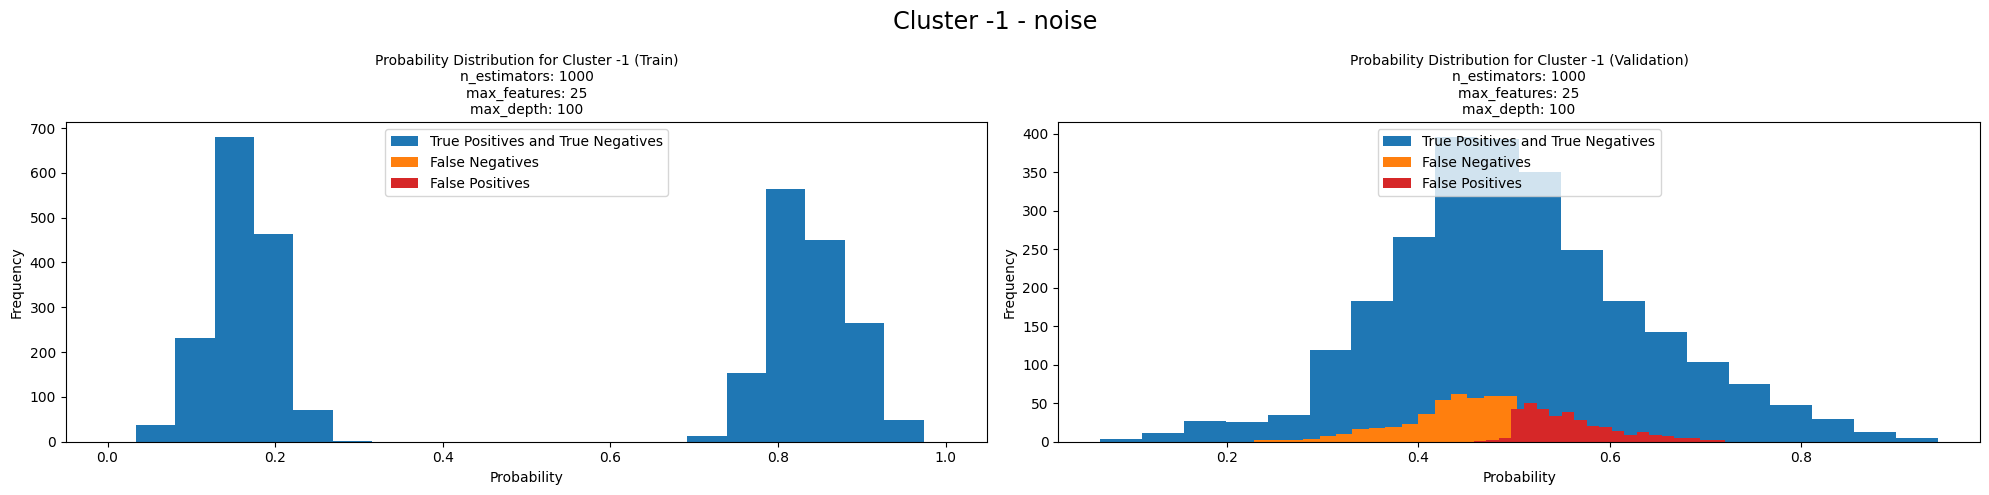

Evaluation Metrics Report Training (Random Forest - Cluster -1)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1483
         1.0       1.00      1.00      1.00      1496

    accuracy                           1.00      2979
   macro avg       1.00      1.00      1.00      2979
weighted avg       1.00      1.00      1.00      2979

Evaluation Metrics Report Validation (Random Forest - Cluster -1)
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71      1324
         1.0       0.72      0.66      0.69      1333

    accuracy                           0.70      2657
   macro avg       0.70      0.70      0.70      2657
weighted avg       0.70      0.70      0.70      2657



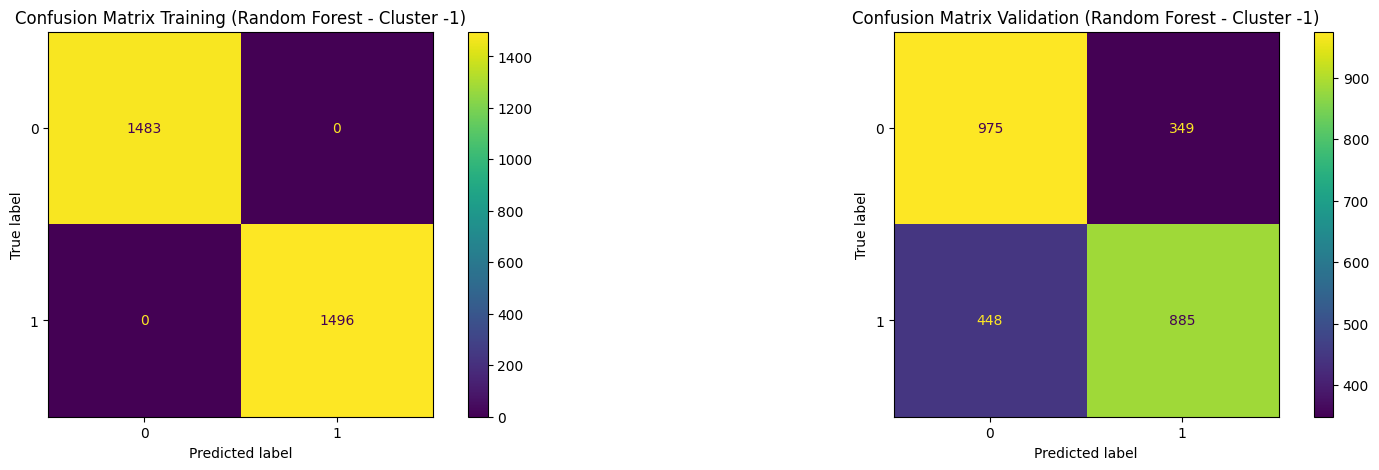

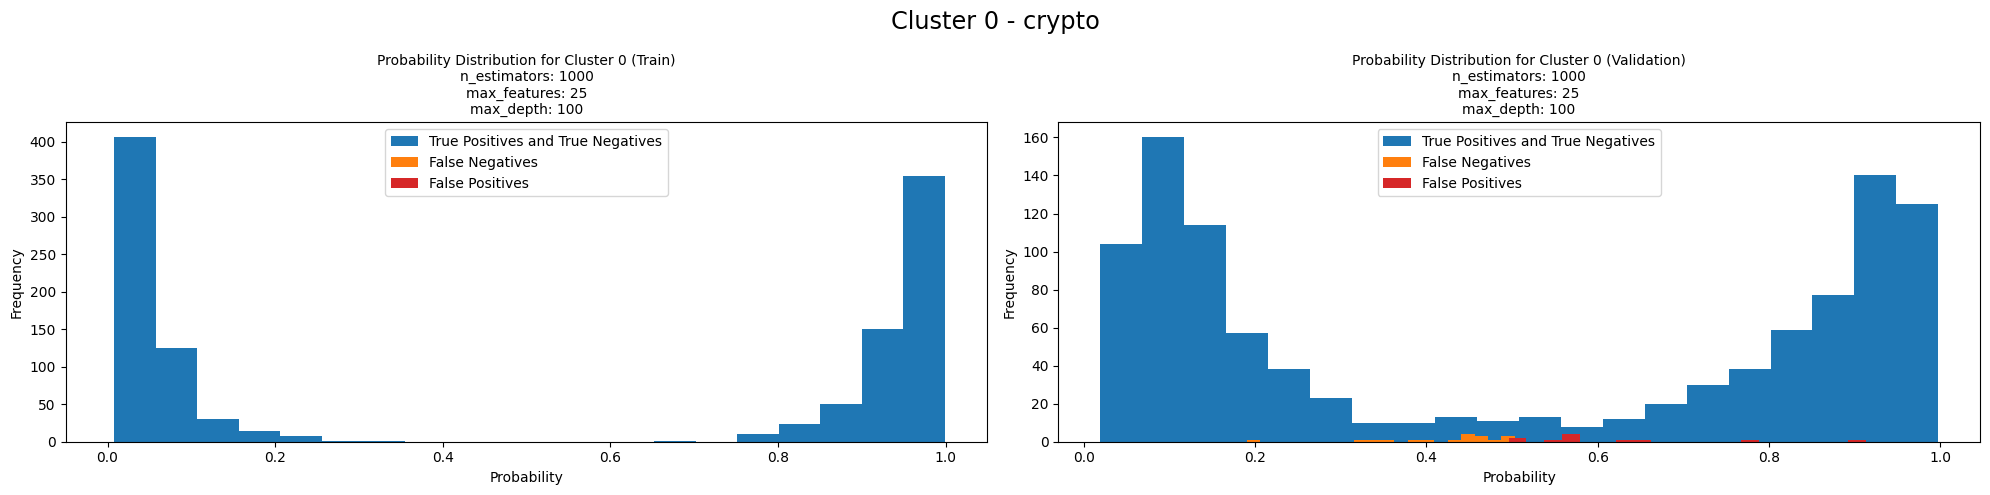

Evaluation Metrics Report Training (Random Forest - Cluster 0)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       584
         1.0       1.00      1.00      1.00       588

    accuracy                           1.00      1172
   macro avg       1.00      1.00      1.00      1172
weighted avg       1.00      1.00      1.00      1172

Evaluation Metrics Report Validation (Random Forest - Cluster 0)
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       531
         1.0       0.98      0.97      0.97       531

    accuracy                           0.97      1062
   macro avg       0.97      0.97      0.97      1062
weighted avg       0.97      0.97      0.97      1062



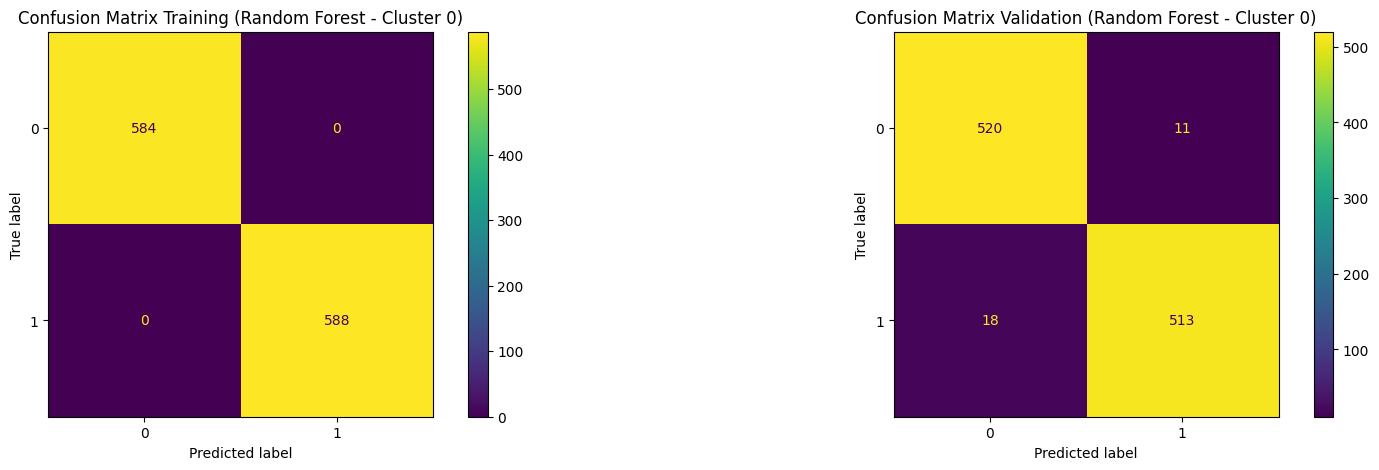

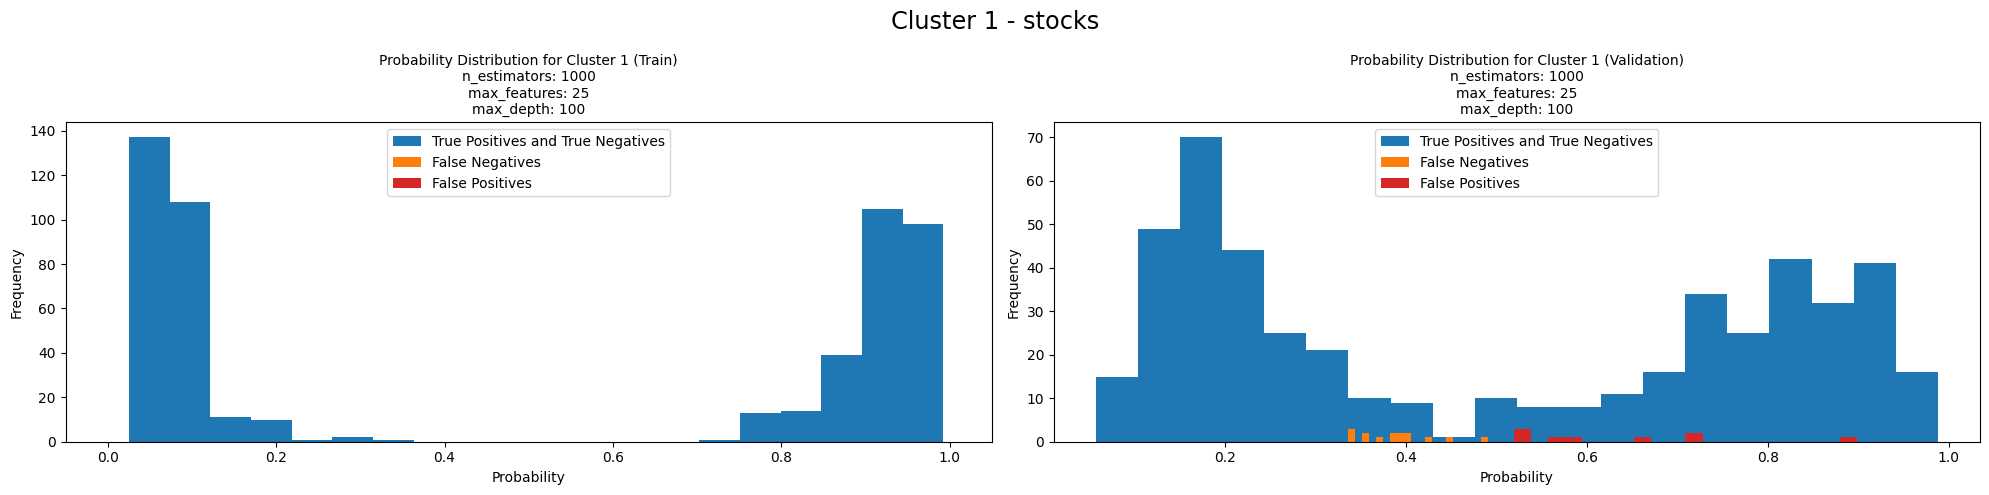

Evaluation Metrics Report Training (Random Forest - Cluster 1)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       270
         1.0       1.00      1.00      1.00       270

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540

Evaluation Metrics Report Validation (Random Forest - Cluster 1)
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       243
         1.0       0.96      0.94      0.95       244

    accuracy                           0.95       487
   macro avg       0.95      0.95      0.95       487
weighted avg       0.95      0.95      0.95       487



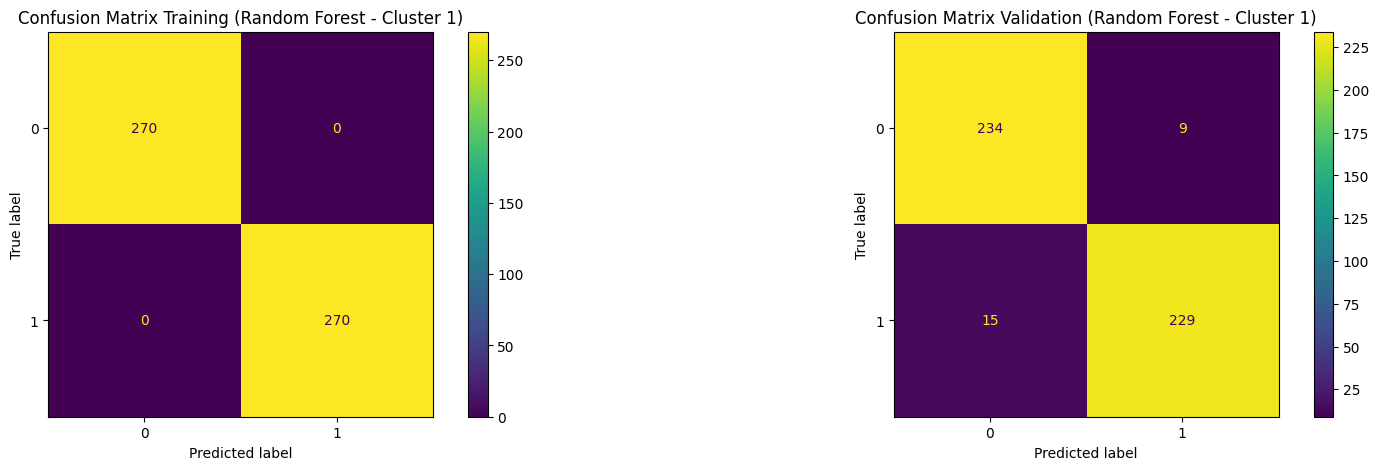

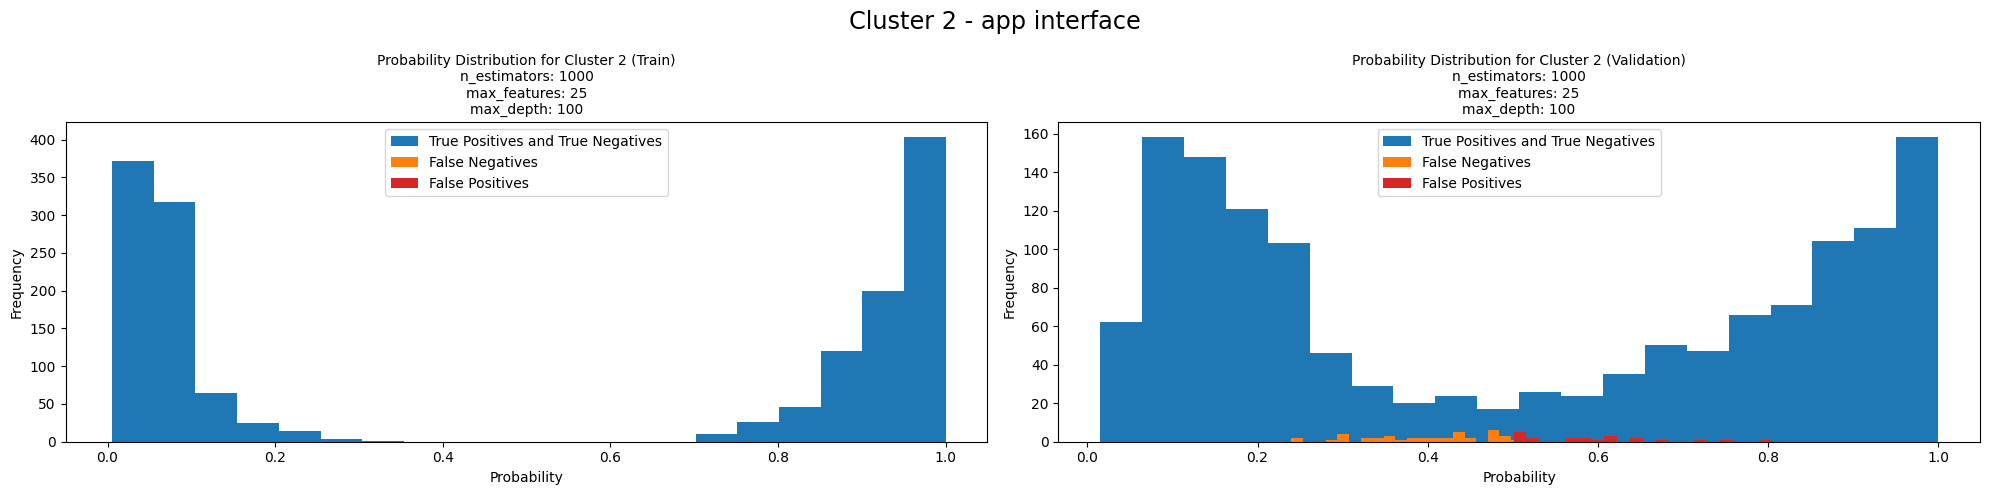

Evaluation Metrics Report Training (Random Forest - Cluster 2)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       798
         1.0       1.00      1.00      1.00       804

    accuracy                           1.00      1602
   macro avg       1.00      1.00      1.00      1602
weighted avg       1.00      1.00      1.00      1602

Evaluation Metrics Report Validation (Random Forest - Cluster 2)
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       708
         1.0       0.97      0.94      0.96       712

    accuracy                           0.96      1420
   macro avg       0.96      0.96      0.96      1420
weighted avg       0.96      0.96      0.96      1420



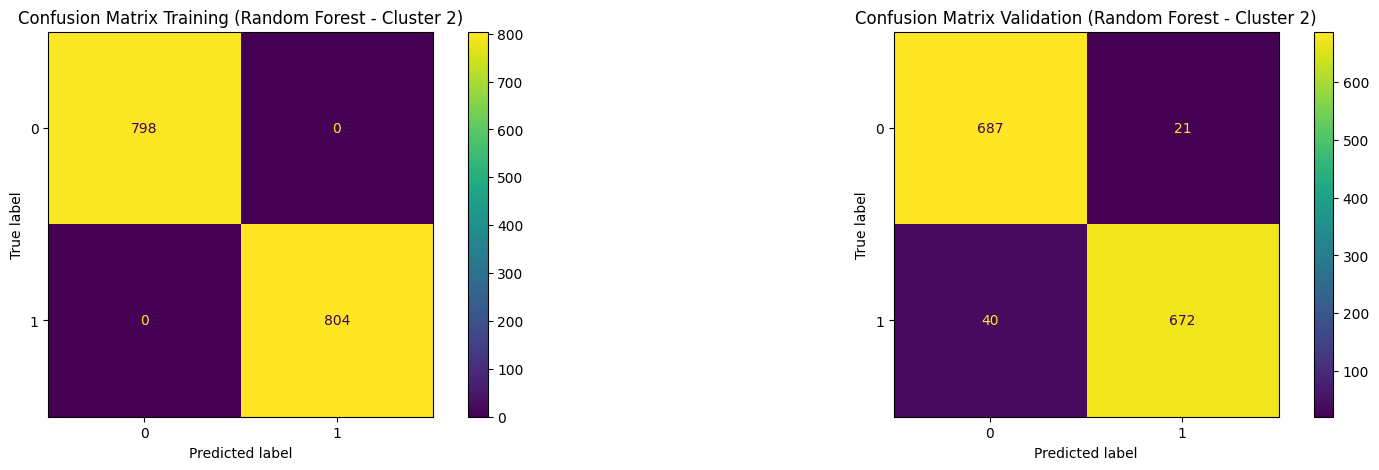

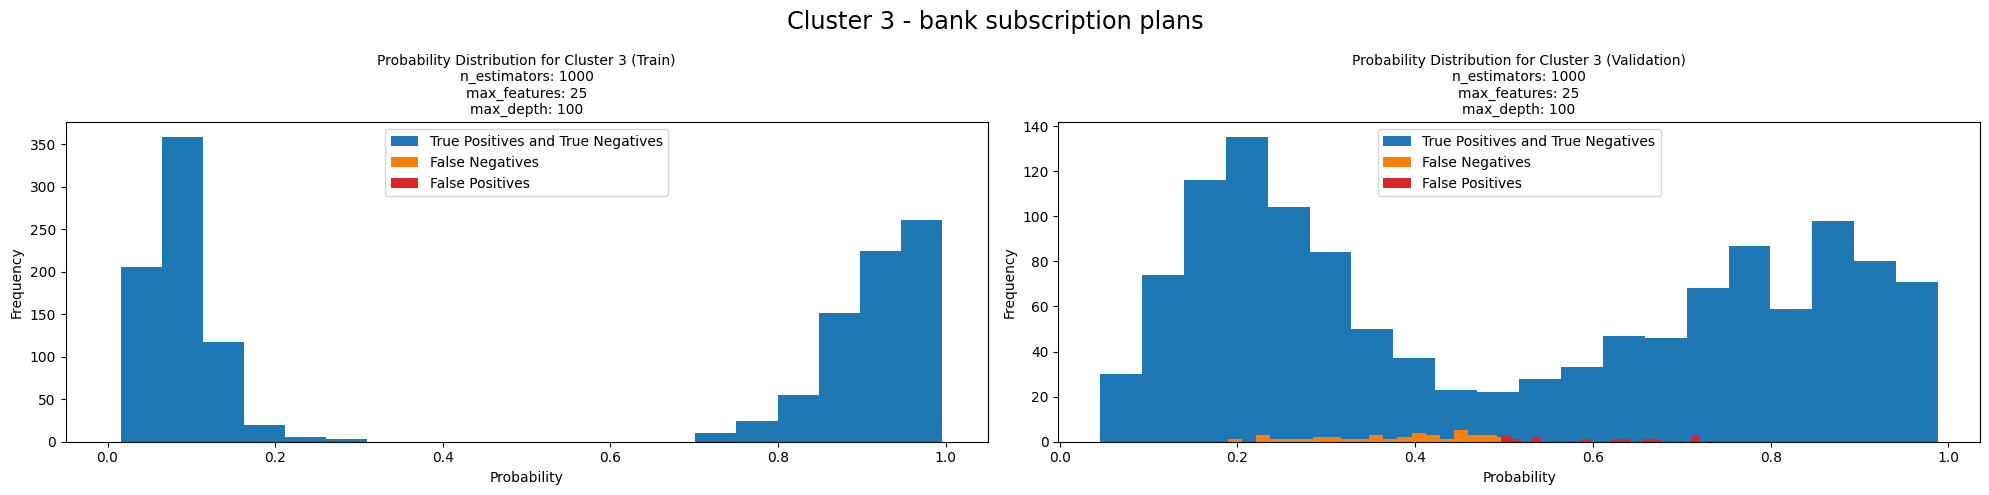

Evaluation Metrics Report Training (Random Forest - Cluster 3)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       709
         1.0       1.00      1.00      1.00       726

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435

Evaluation Metrics Report Validation (Random Forest - Cluster 3)
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       638
         1.0       0.98      0.94      0.96       654

    accuracy                           0.96      1292
   macro avg       0.96      0.96      0.96      1292
weighted avg       0.96      0.96      0.96      1292



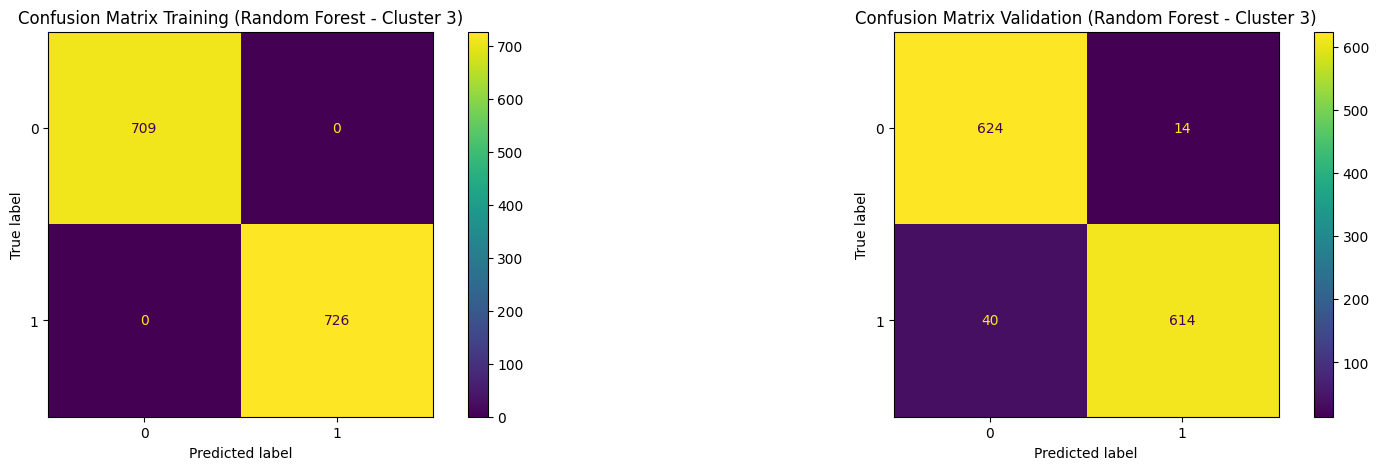

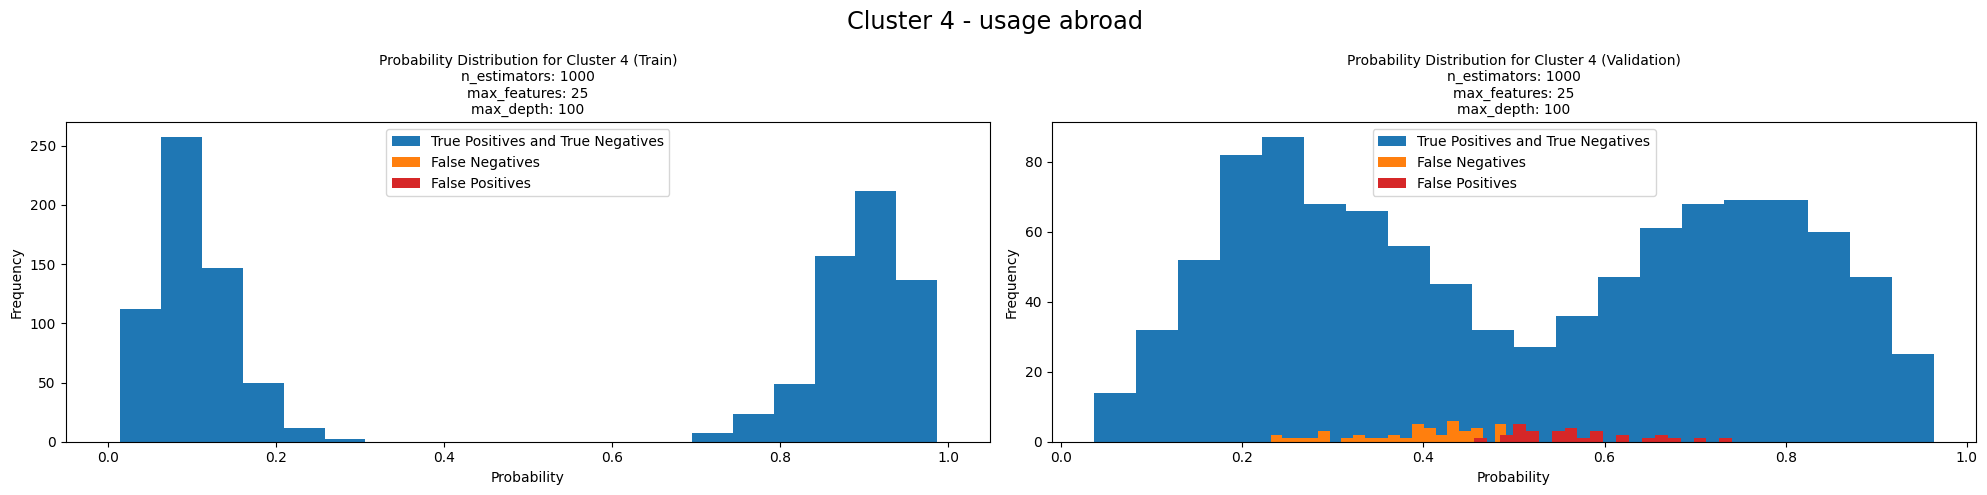

Evaluation Metrics Report Training (Random Forest - Cluster 4)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       580
         1.0       1.00      1.00      1.00       585

    accuracy                           1.00      1165
   macro avg       1.00      1.00      1.00      1165
weighted avg       1.00      1.00      1.00      1165

Evaluation Metrics Report Validation (Random Forest - Cluster 4)
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       515
         1.0       0.94      0.91      0.93       528

    accuracy                           0.93      1043
   macro avg       0.93      0.93      0.93      1043
weighted avg       0.93      0.93      0.93      1043



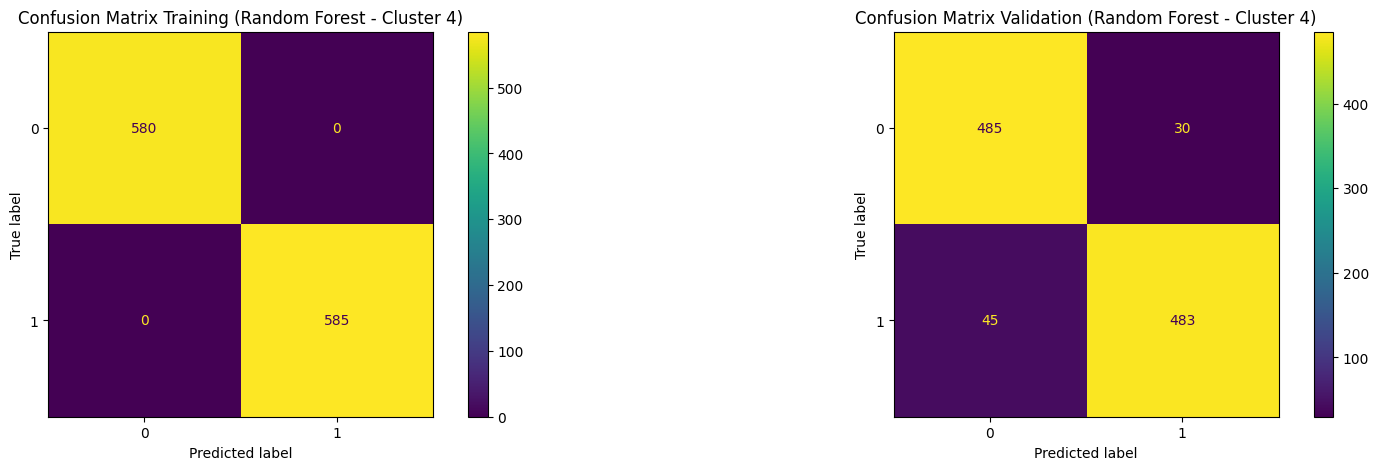

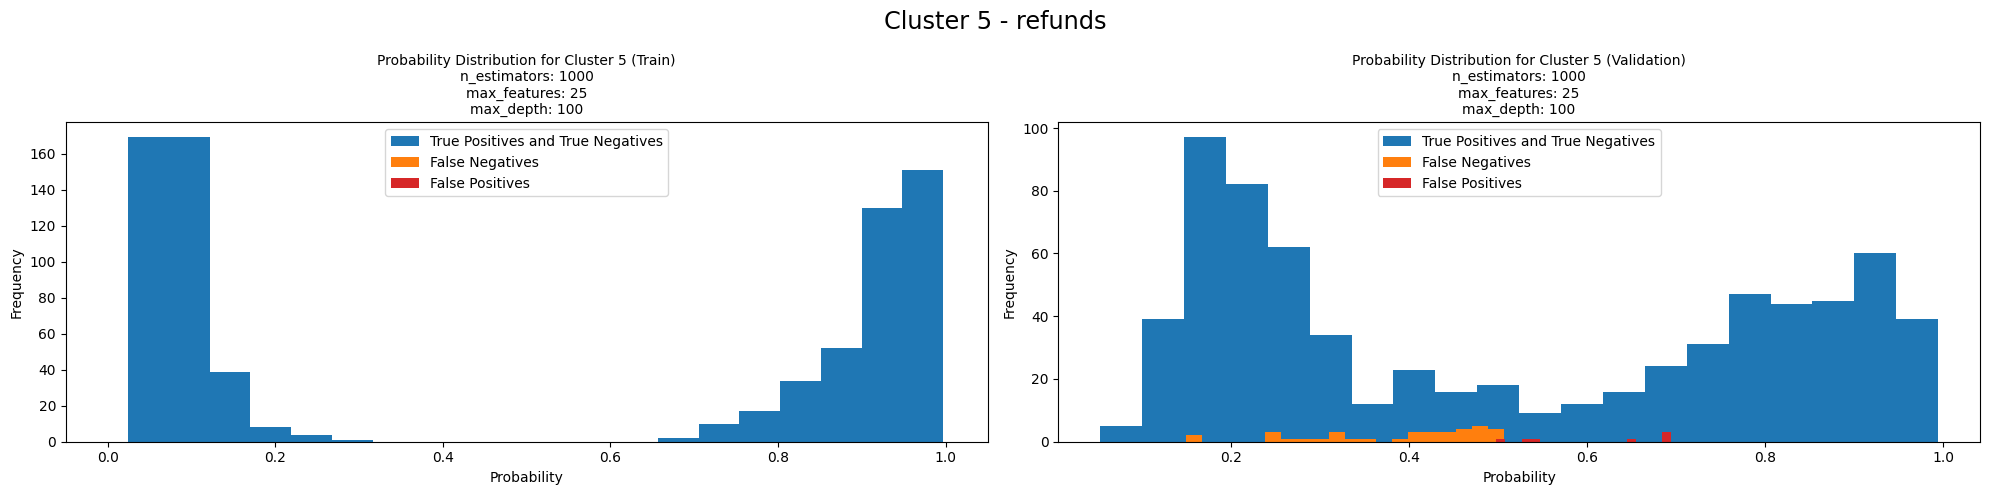

Evaluation Metrics Report Training (Random Forest - Cluster 5)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       390
         1.0       1.00      1.00      1.00       396

    accuracy                           1.00       786
   macro avg       1.00      1.00      1.00       786
weighted avg       1.00      1.00      1.00       786

Evaluation Metrics Report Validation (Random Forest - Cluster 5)
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       352
         1.0       0.98      0.90      0.94       363

    accuracy                           0.94       715
   macro avg       0.94      0.94      0.94       715
weighted avg       0.94      0.94      0.94       715



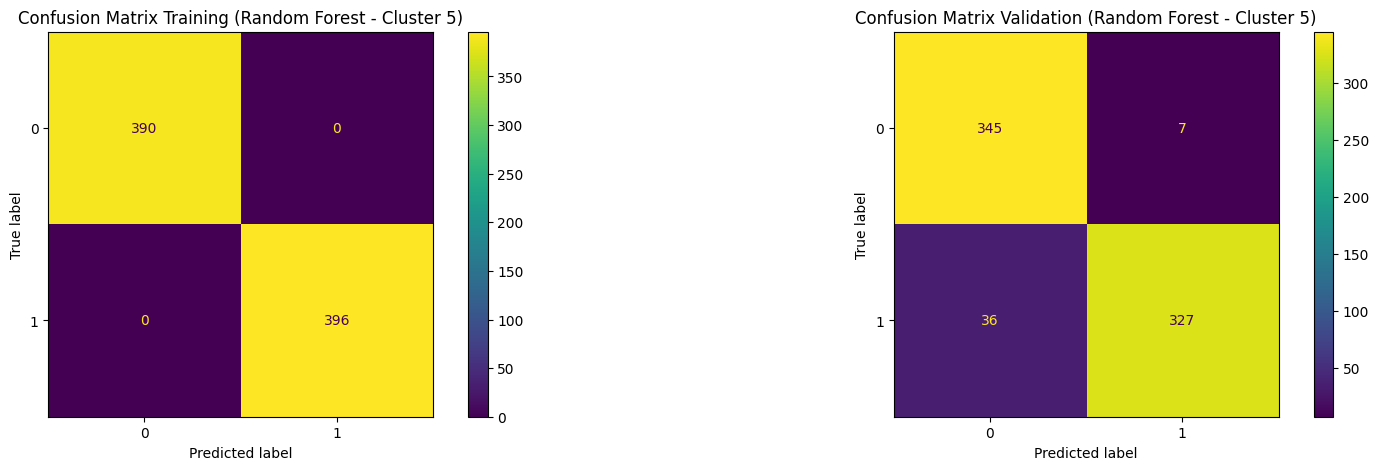

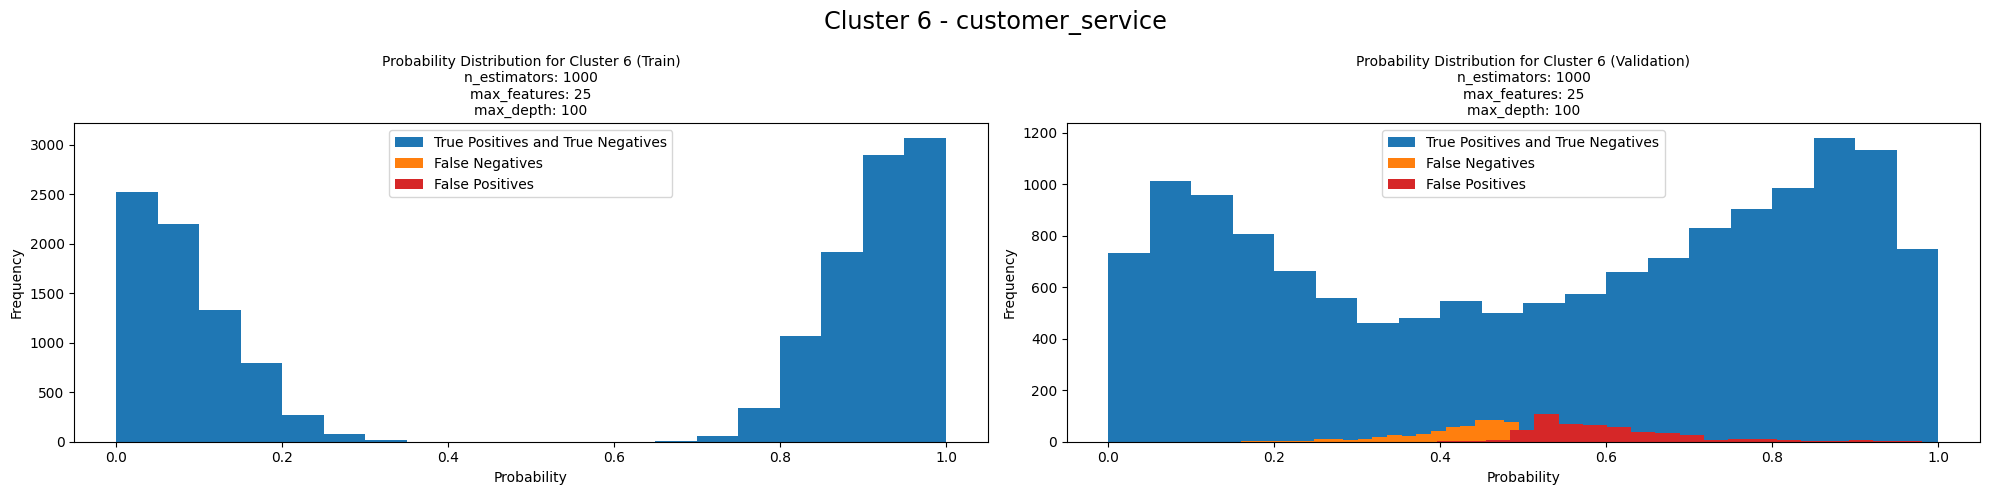

Evaluation Metrics Report Training (Random Forest - Cluster 6)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7217
         1.0       1.00      1.00      1.00      9326

    accuracy                           1.00     16543
   macro avg       1.00      1.00      1.00     16543
weighted avg       1.00      1.00      1.00     16543

Evaluation Metrics Report Validation (Random Forest - Cluster 6)
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      6608
         1.0       0.94      0.93      0.93      8370

    accuracy                           0.93     14978
   macro avg       0.93      0.93      0.93     14978
weighted avg       0.93      0.93      0.93     14978



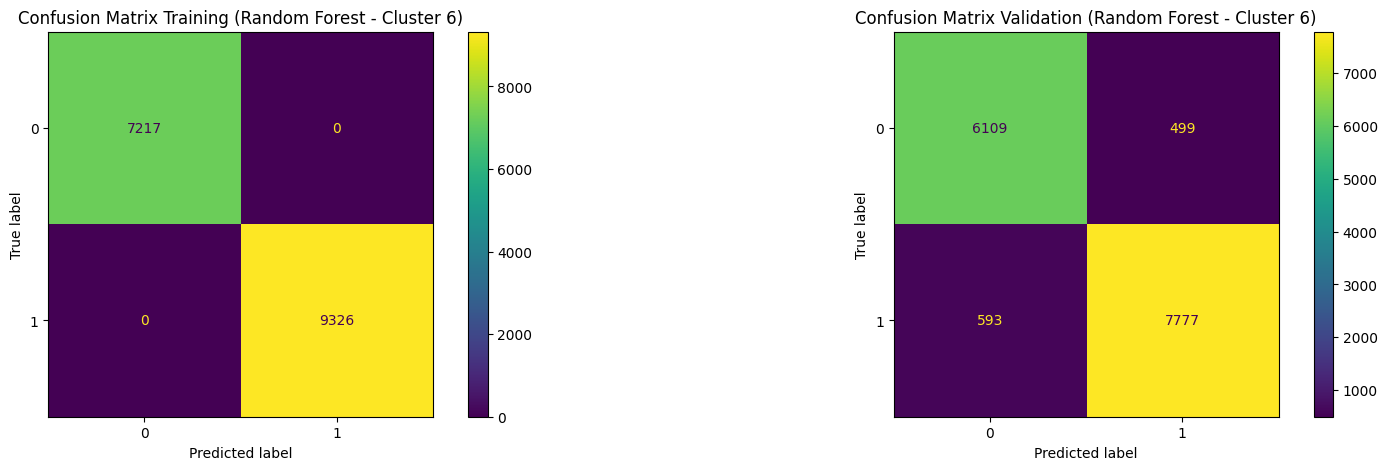

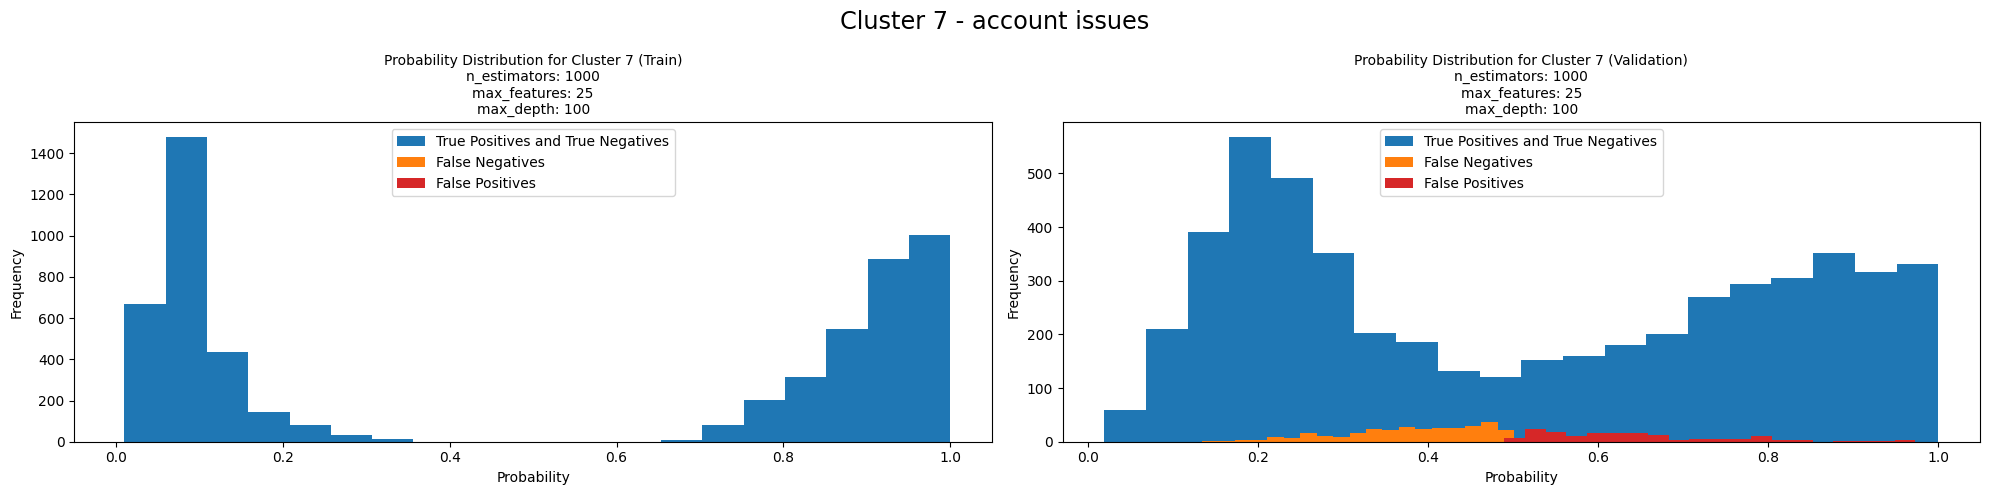

Evaluation Metrics Report Training (Random Forest - Cluster 7)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2856
         1.0       1.00      1.00      1.00      3043

    accuracy                           1.00      5899
   macro avg       1.00      1.00      1.00      5899
weighted avg       1.00      1.00      1.00      5899

Evaluation Metrics Report Validation (Random Forest - Cluster 7)
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      2544
         1.0       0.94      0.88      0.91      2726

    accuracy                           0.91      5270
   macro avg       0.91      0.91      0.91      5270
weighted avg       0.91      0.91      0.91      5270



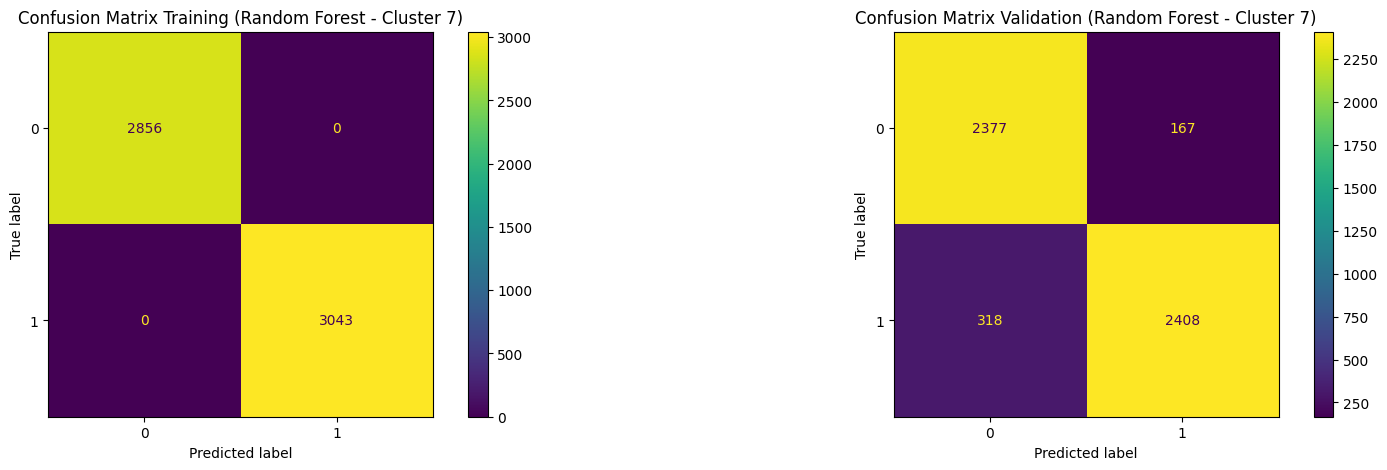

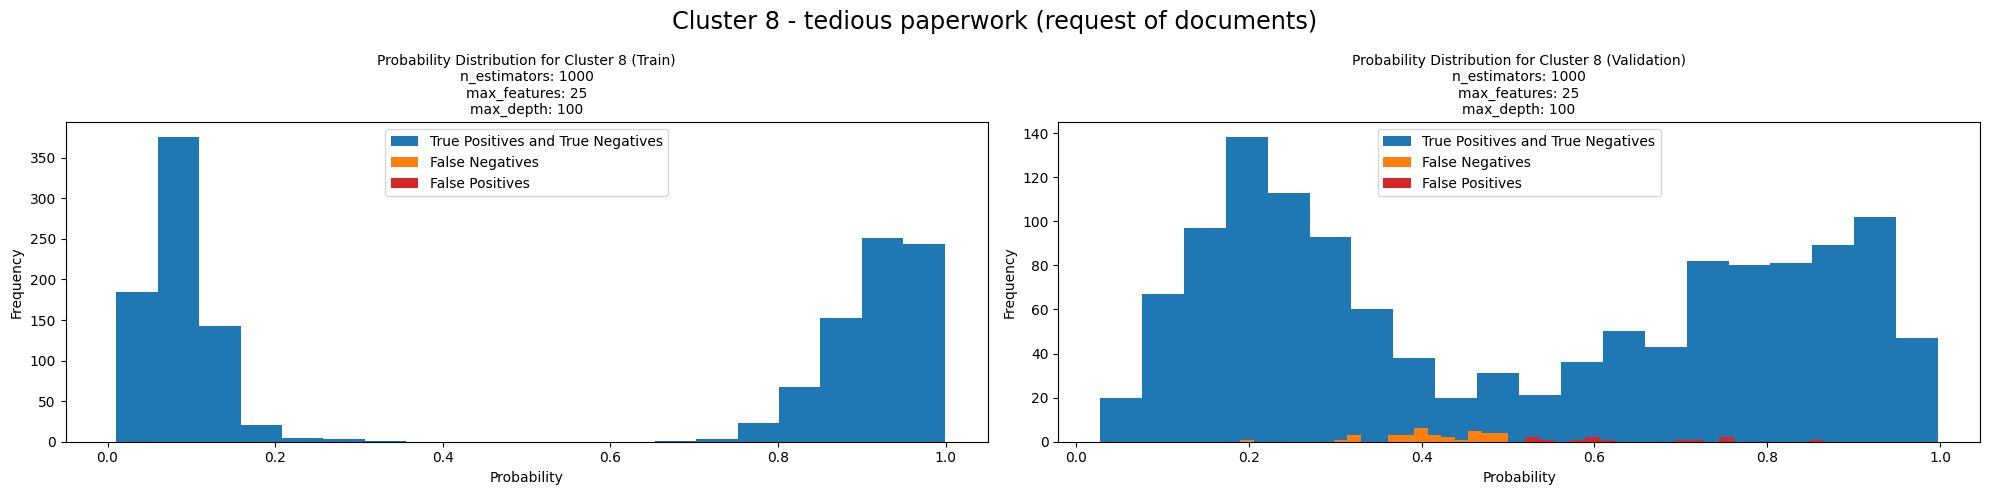

Evaluation Metrics Report Training (Random Forest - Cluster 8)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       730
         1.0       1.00      1.00      1.00       741

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

Evaluation Metrics Report Validation (Random Forest - Cluster 8)
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       644
         1.0       0.98      0.95      0.96       664

    accuracy                           0.96      1308
   macro avg       0.96      0.96      0.96      1308
weighted avg       0.96      0.96      0.96      1308



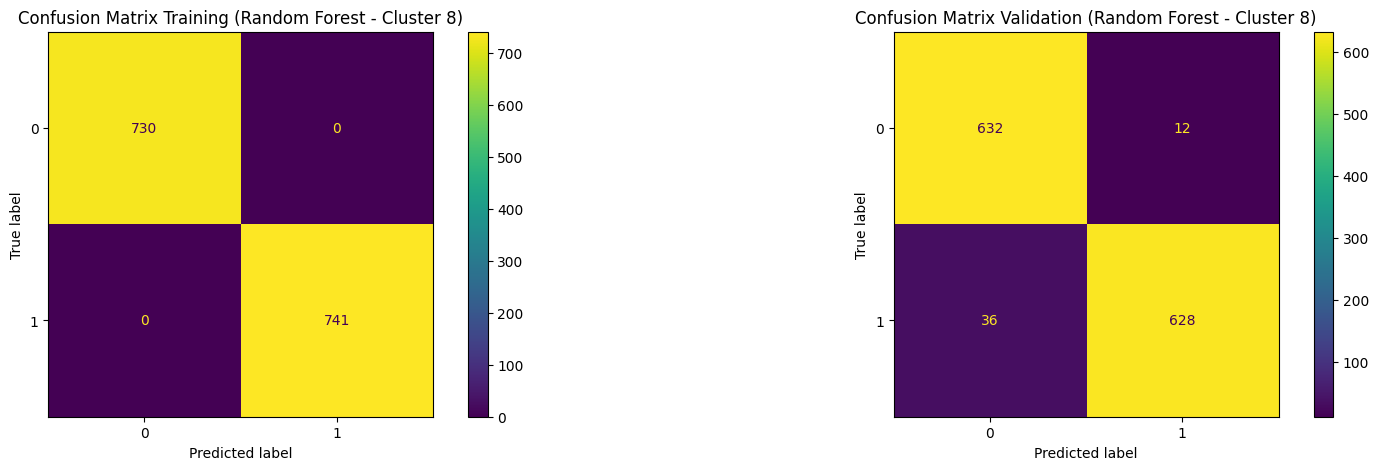

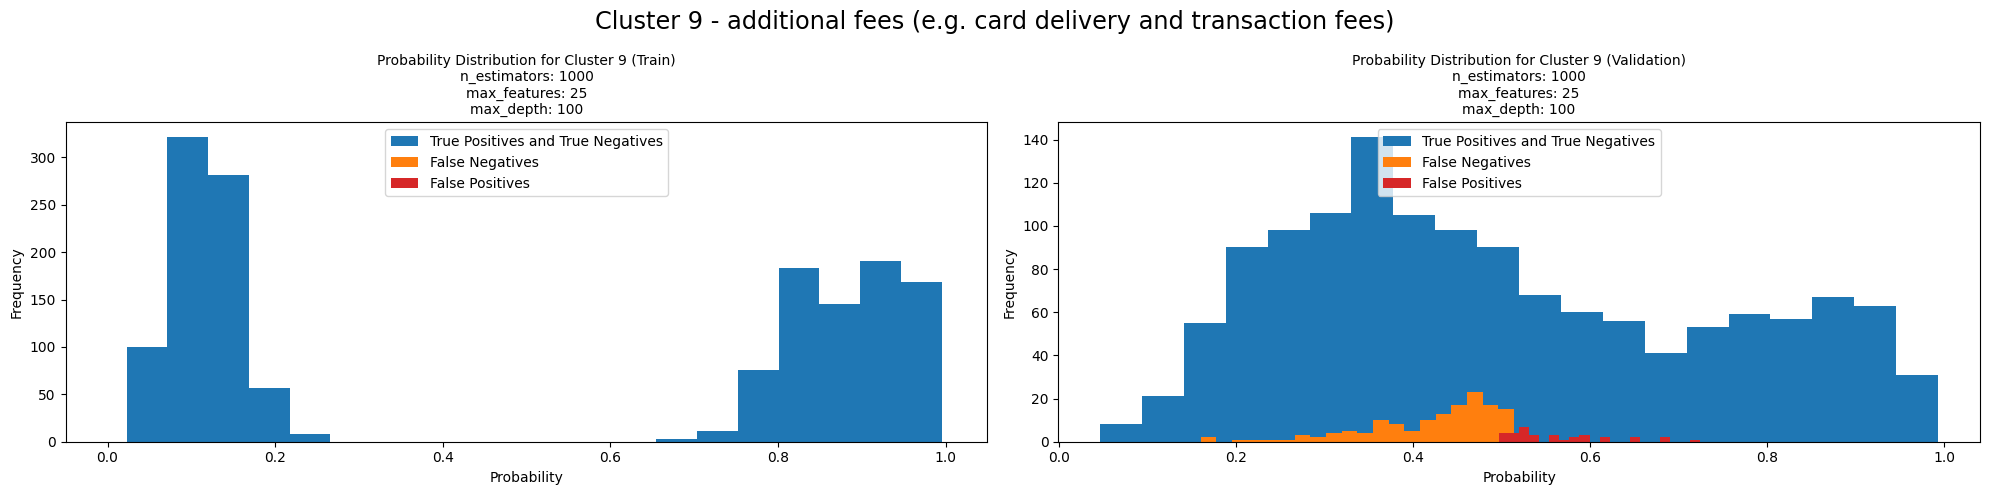

Evaluation Metrics Report Training (Random Forest - Cluster 9)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       767
         1.0       1.00      1.00      1.00       777

    accuracy                           1.00      1544
   macro avg       1.00      1.00      1.00      1544
weighted avg       1.00      1.00      1.00      1544

Evaluation Metrics Report Validation (Random Forest - Cluster 9)
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       672
         1.0       0.94      0.80      0.86       695

    accuracy                           0.87      1367
   macro avg       0.88      0.87      0.87      1367
weighted avg       0.88      0.87      0.87      1367



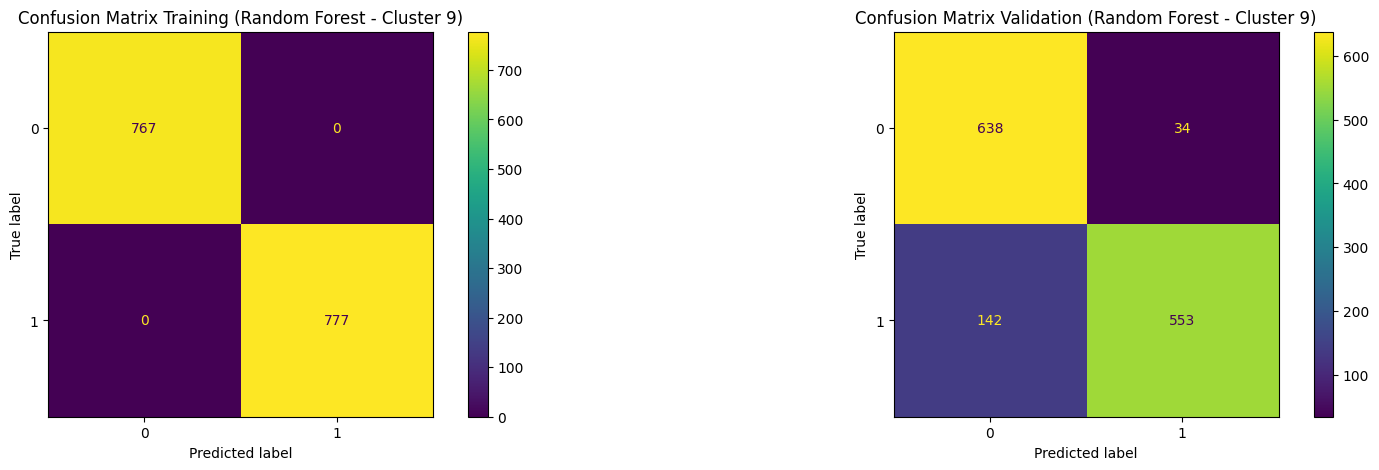

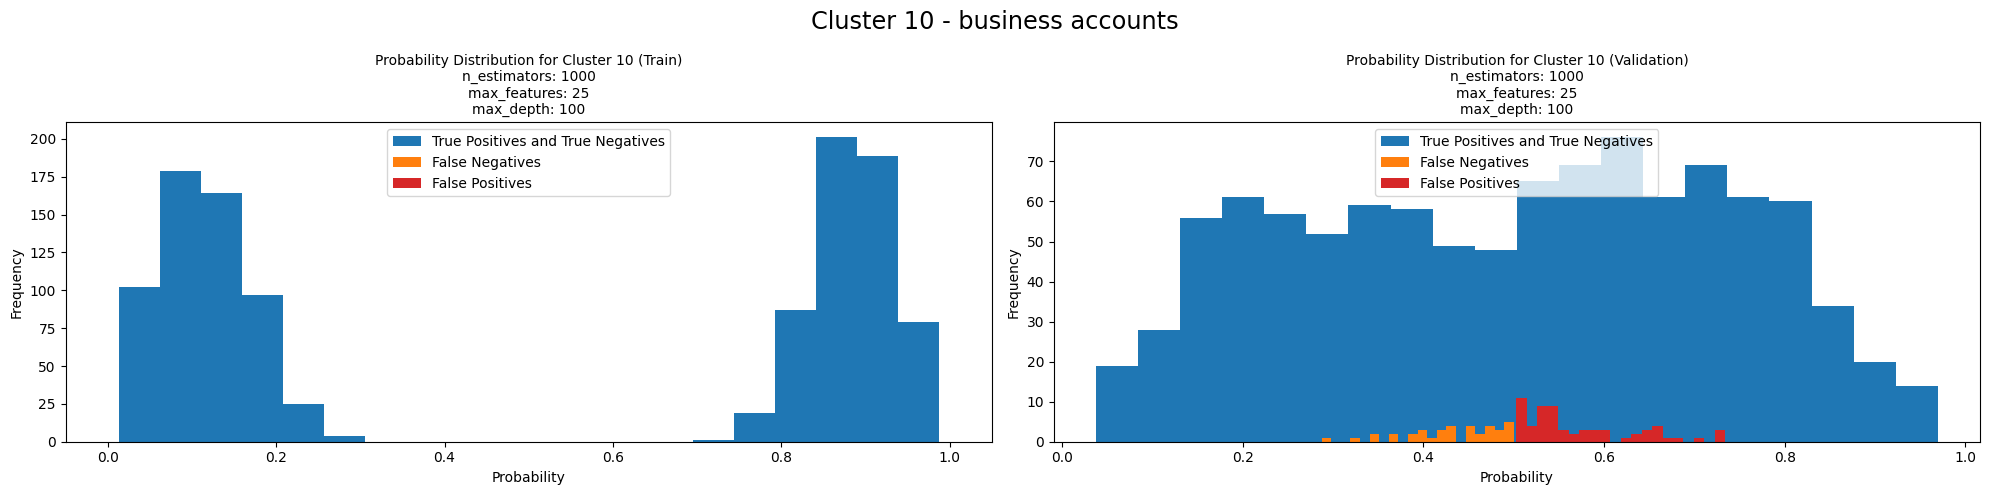

Evaluation Metrics Report Training (Random Forest - Cluster 10)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       571
         1.0       1.00      1.00      1.00       576

    accuracy                           1.00      1147
   macro avg       1.00      1.00      1.00      1147
weighted avg       1.00      1.00      1.00      1147

Evaluation Metrics Report Validation (Random Forest - Cluster 10)
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       510
         1.0       0.88      0.93      0.90       506

    accuracy                           0.90      1016
   macro avg       0.90      0.90      0.90      1016
weighted avg       0.90      0.90      0.90      1016



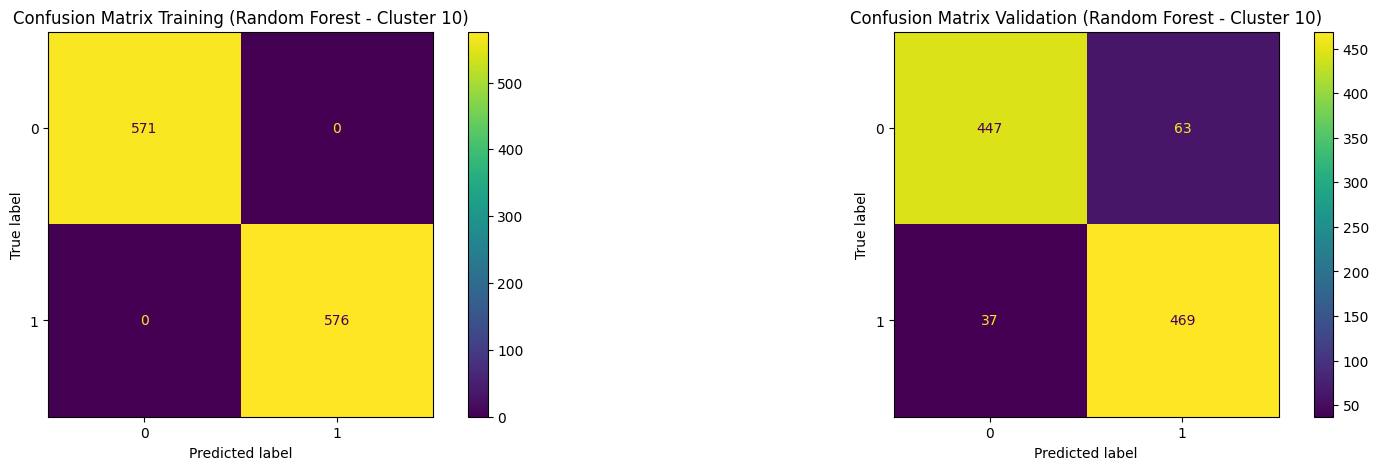

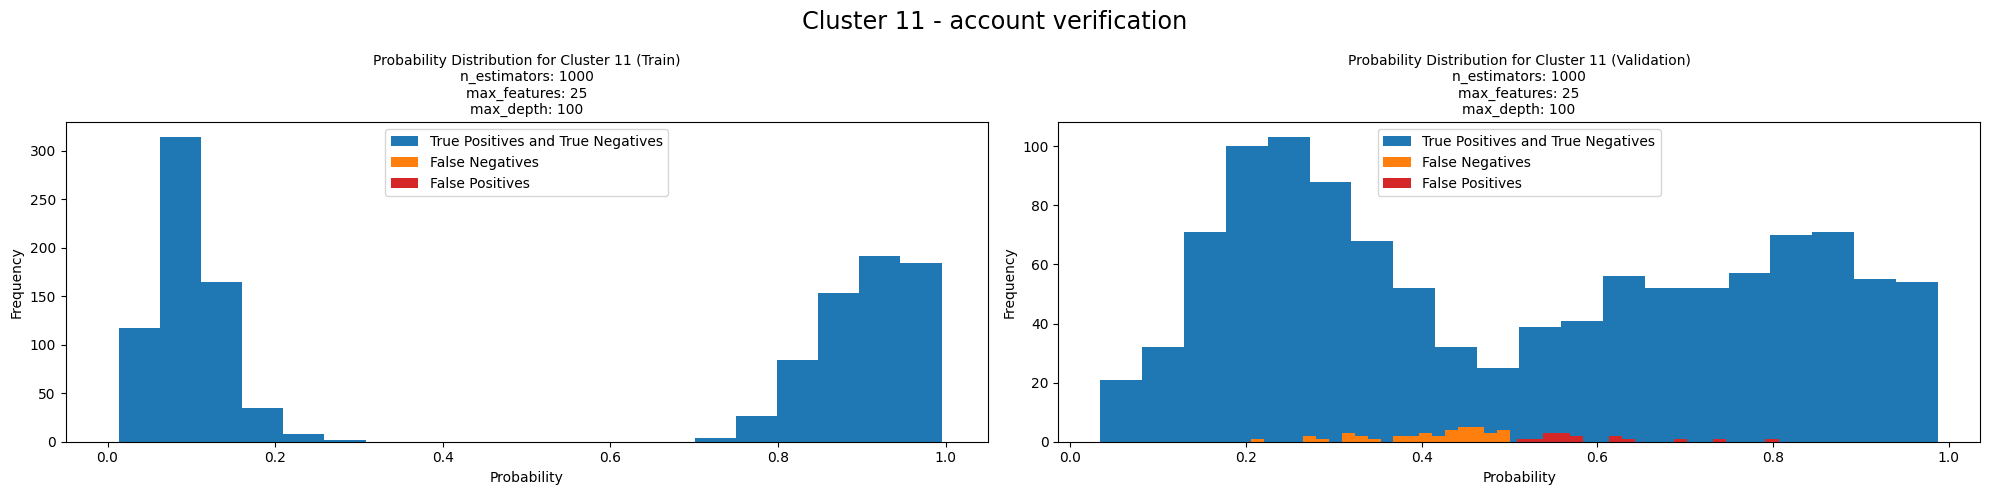

Evaluation Metrics Report Training (Random Forest - Cluster 11)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       641
         1.0       1.00      1.00      1.00       644

    accuracy                           1.00      1285
   macro avg       1.00      1.00      1.00      1285
weighted avg       1.00      1.00      1.00      1285

Evaluation Metrics Report Validation (Random Forest - Cluster 11)
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       562
         1.0       0.97      0.93      0.95       577

    accuracy                           0.95      1139
   macro avg       0.95      0.95      0.95      1139
weighted avg       0.95      0.95      0.95      1139



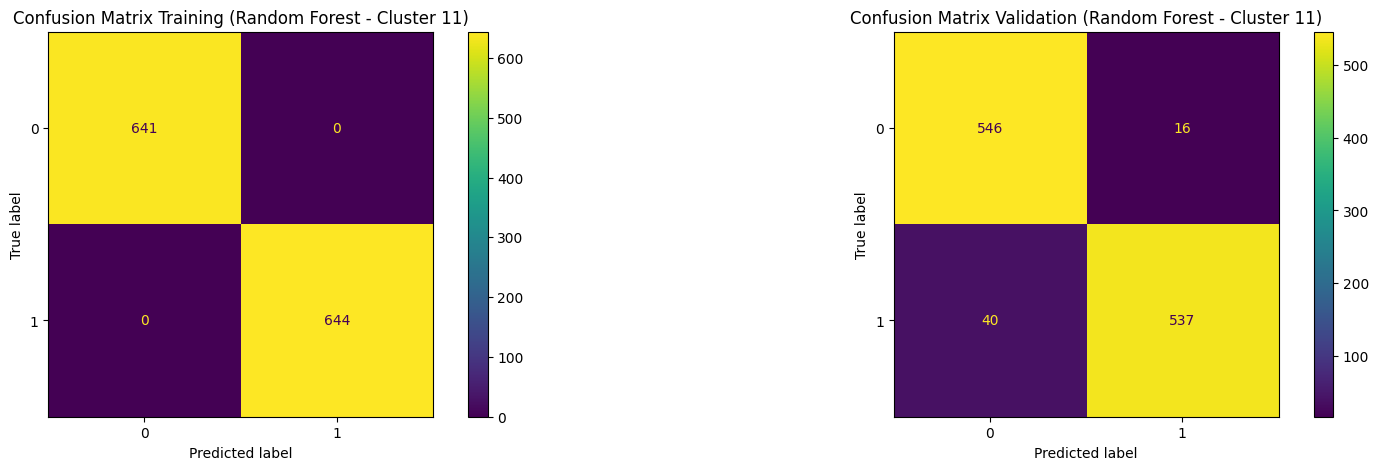

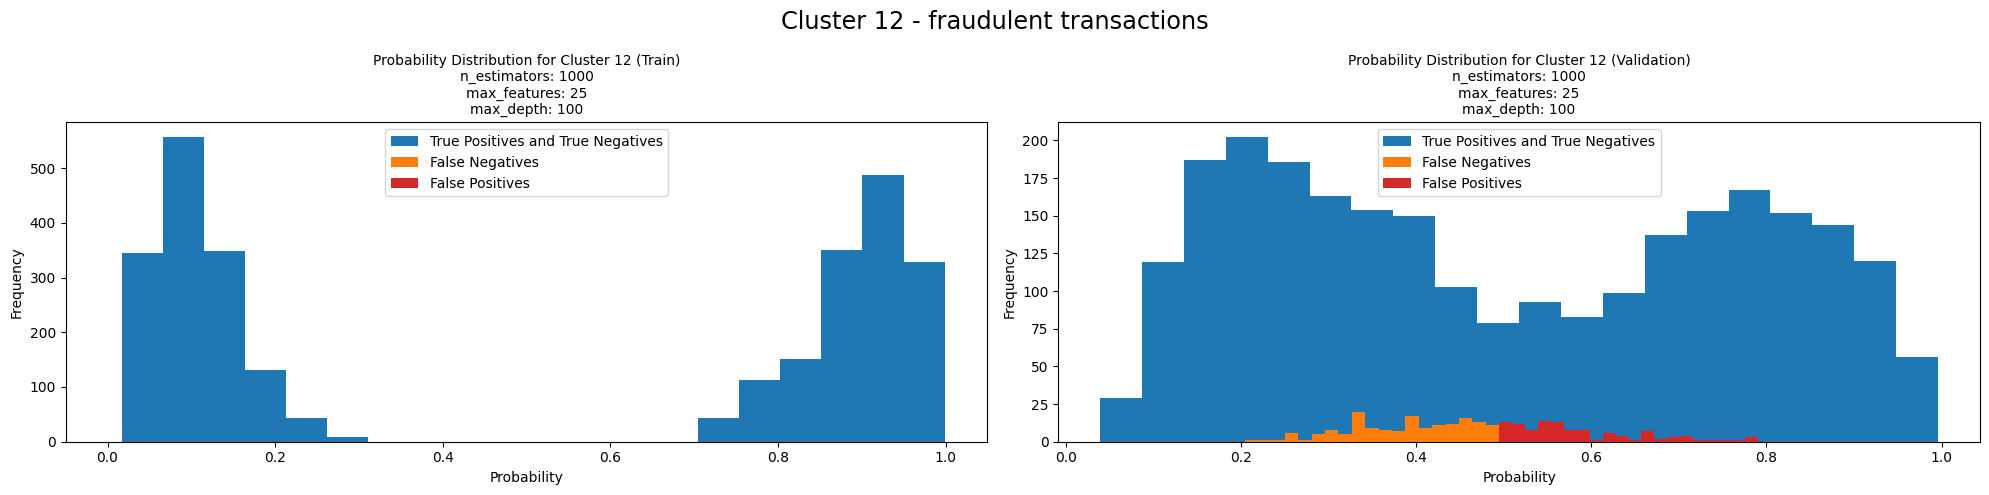

Evaluation Metrics Report Training (Random Forest - Cluster 12)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1432
         1.0       1.00      1.00      1.00      1474

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906

Evaluation Metrics Report Validation (Random Forest - Cluster 12)
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90      1284
         1.0       0.91      0.87      0.89      1292

    accuracy                           0.89      2576
   macro avg       0.89      0.89      0.89      2576
weighted avg       0.89      0.89      0.89      2576



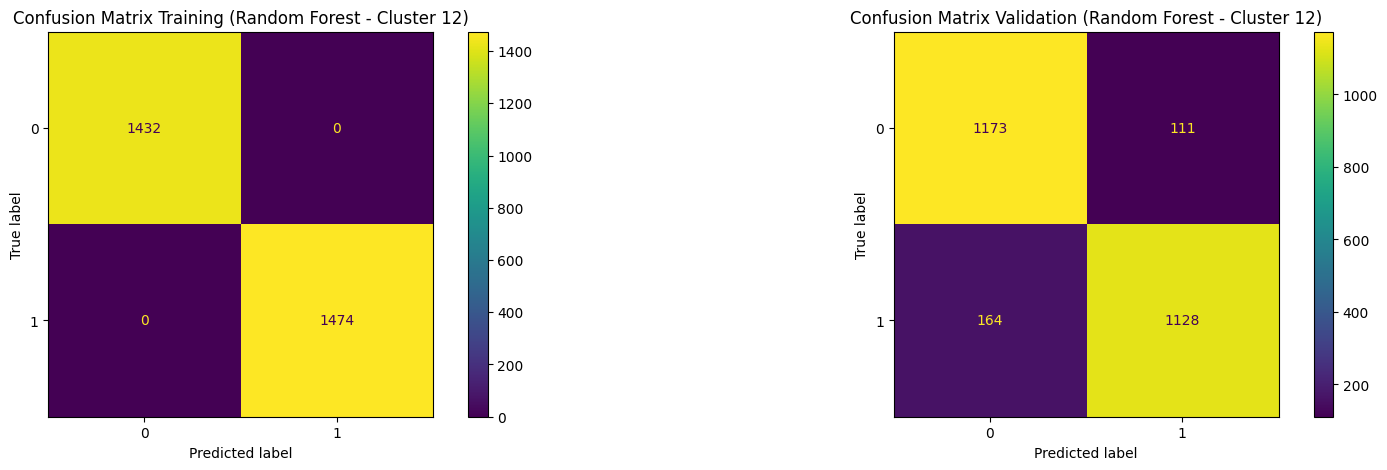

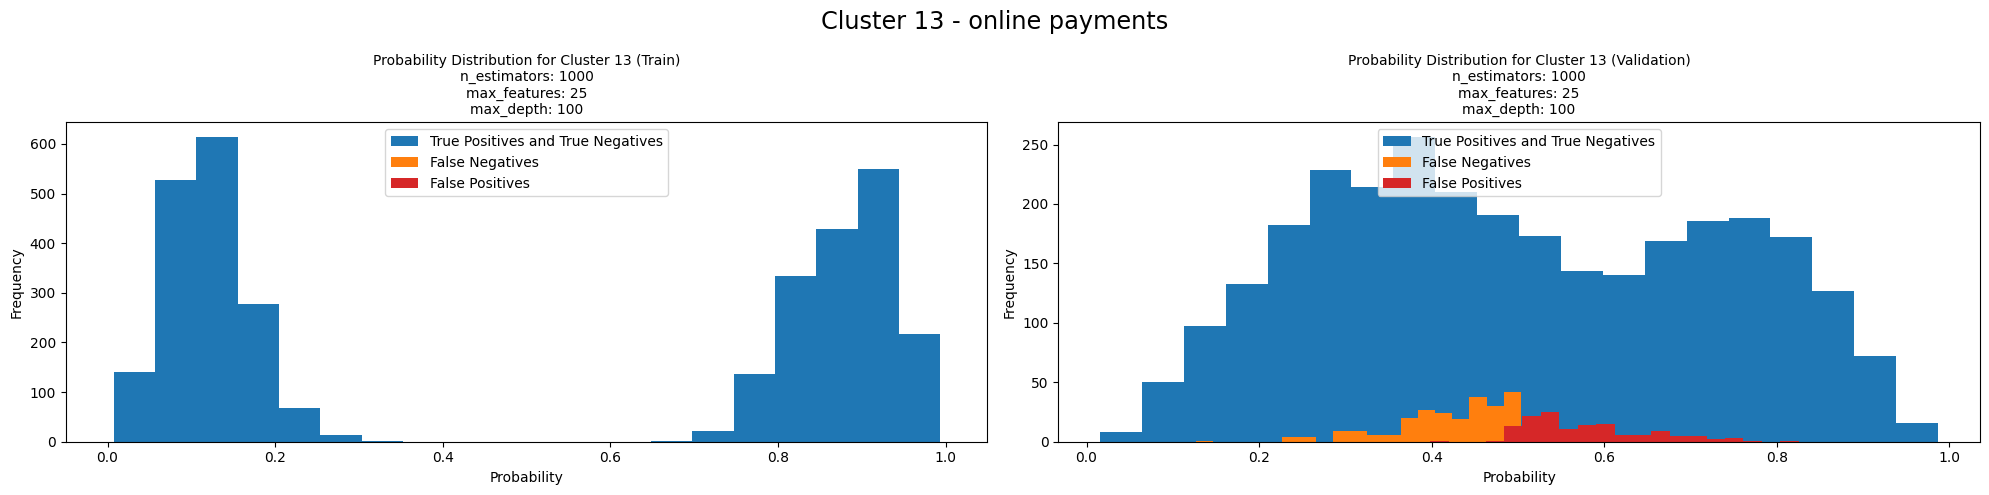

Evaluation Metrics Report Training (Random Forest - Cluster 13)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1640
         1.0       1.00      1.00      1.00      1687

    accuracy                           1.00      3327
   macro avg       1.00      1.00      1.00      3327
weighted avg       1.00      1.00      1.00      3327

Evaluation Metrics Report Validation (Random Forest - Cluster 13)
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1463
         1.0       0.90      0.84      0.87      1494

    accuracy                           0.87      2957
   macro avg       0.87      0.87      0.87      2957
weighted avg       0.87      0.87      0.87      2957



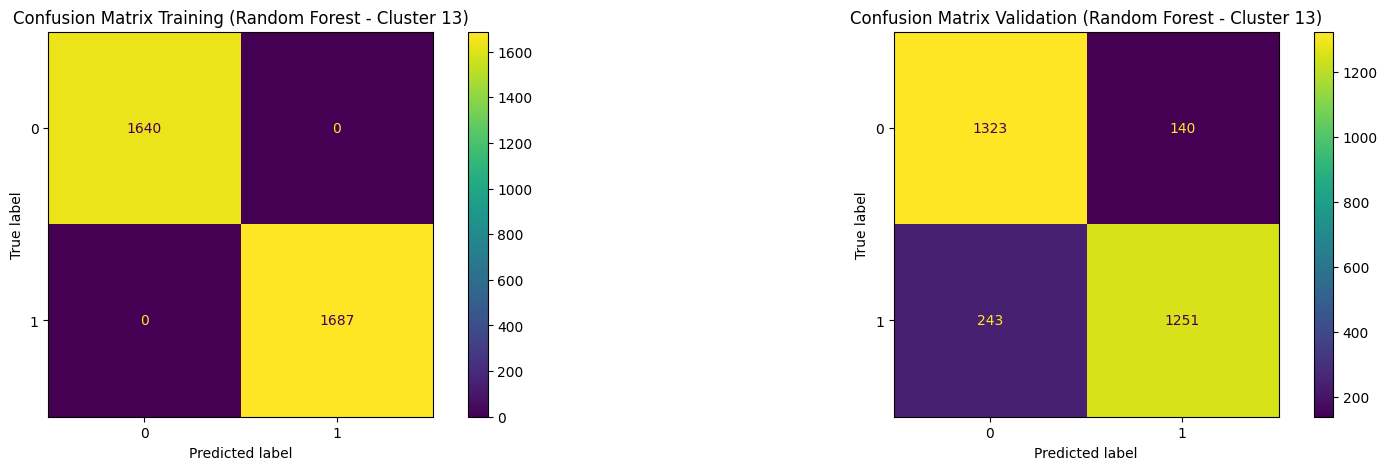

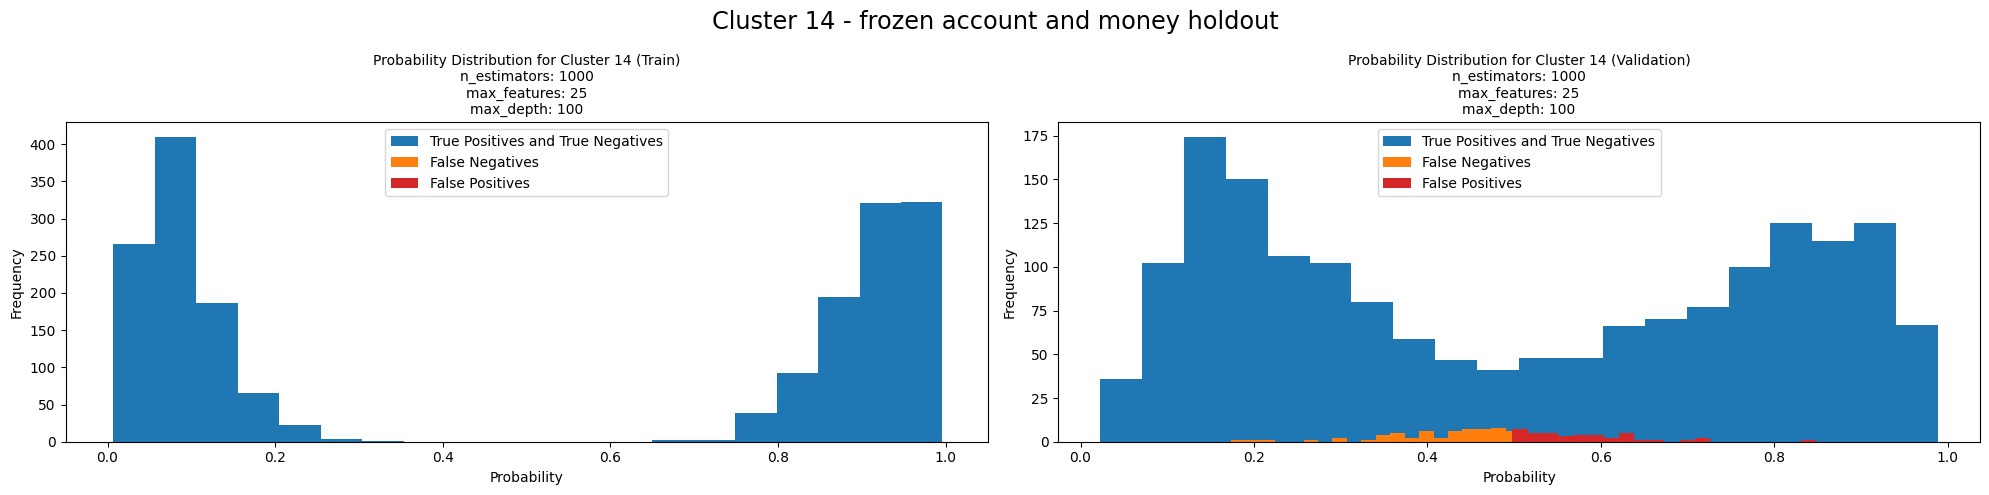

Evaluation Metrics Report Training (Random Forest - Cluster 14)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       954
         1.0       1.00      1.00      1.00       972

    accuracy                           1.00      1926
   macro avg       1.00      1.00      1.00      1926
weighted avg       1.00      1.00      1.00      1926

Evaluation Metrics Report Validation (Random Forest - Cluster 14)
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       873
         1.0       0.95      0.93      0.94       865

    accuracy                           0.94      1738
   macro avg       0.94      0.94      0.94      1738
weighted avg       0.94      0.94      0.94      1738



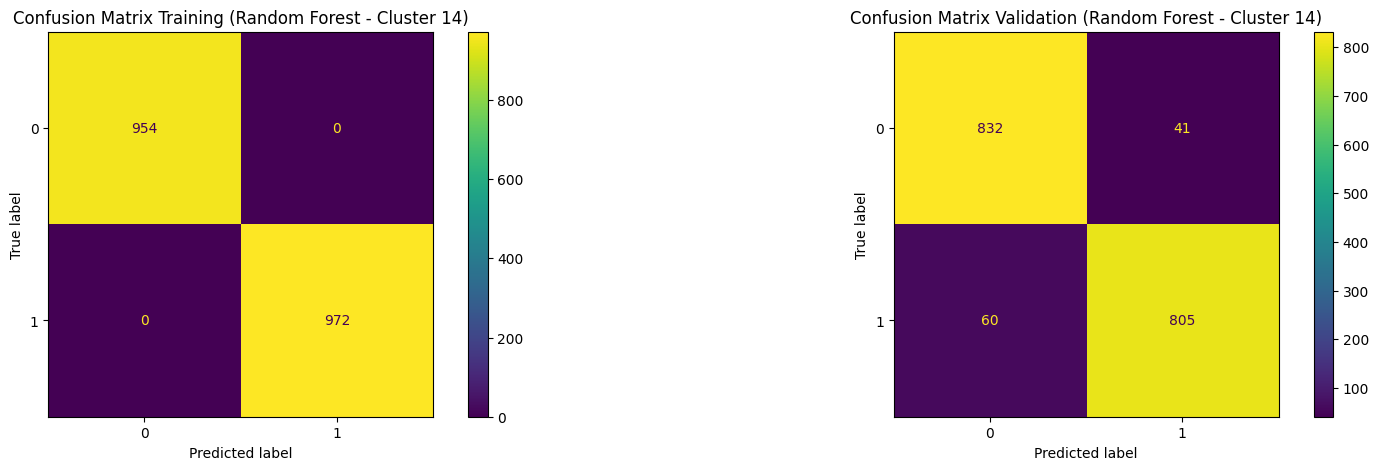

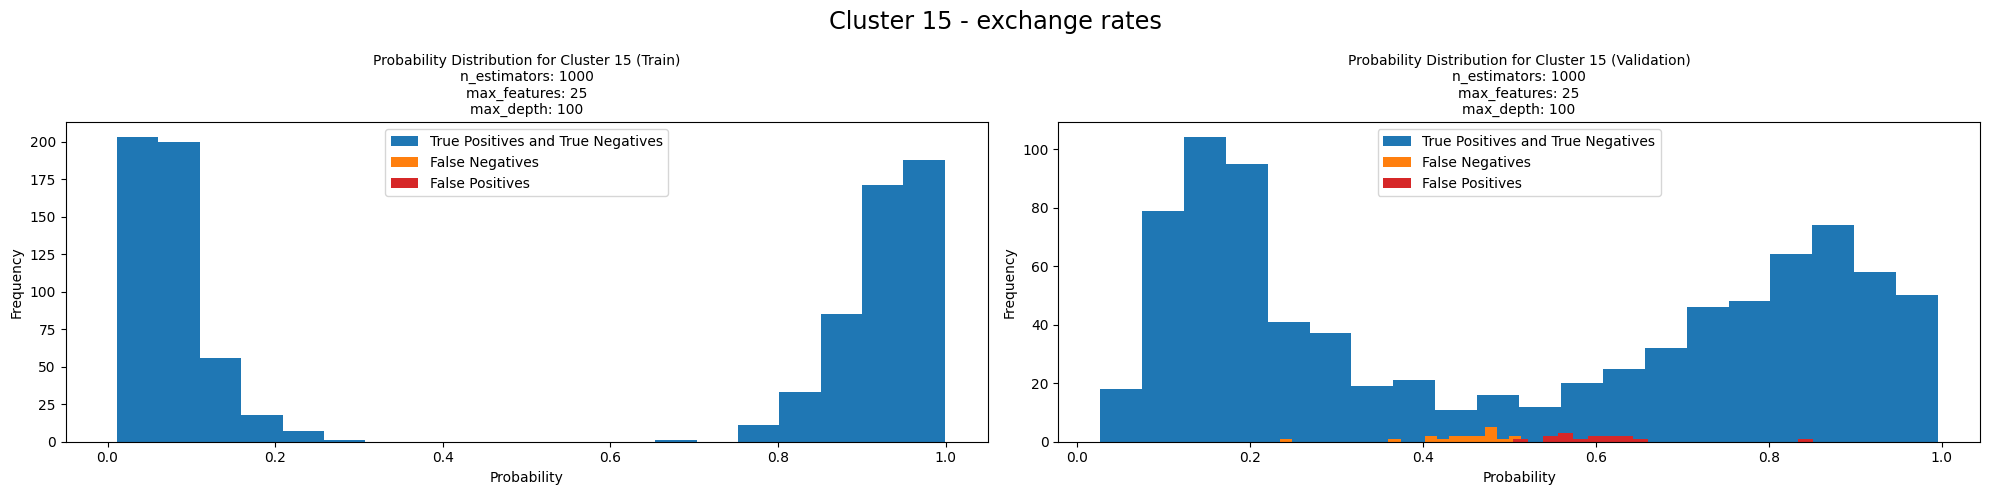

Evaluation Metrics Report Training (Random Forest - Cluster 15)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       485
         1.0       1.00      1.00      1.00       489

    accuracy                           1.00       974
   macro avg       1.00      1.00      1.00       974
weighted avg       1.00      1.00      1.00       974

Evaluation Metrics Report Validation (Random Forest - Cluster 15)
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       435
         1.0       0.97      0.96      0.96       435

    accuracy                           0.96       870
   macro avg       0.96      0.96      0.96       870
weighted avg       0.96      0.96      0.96       870



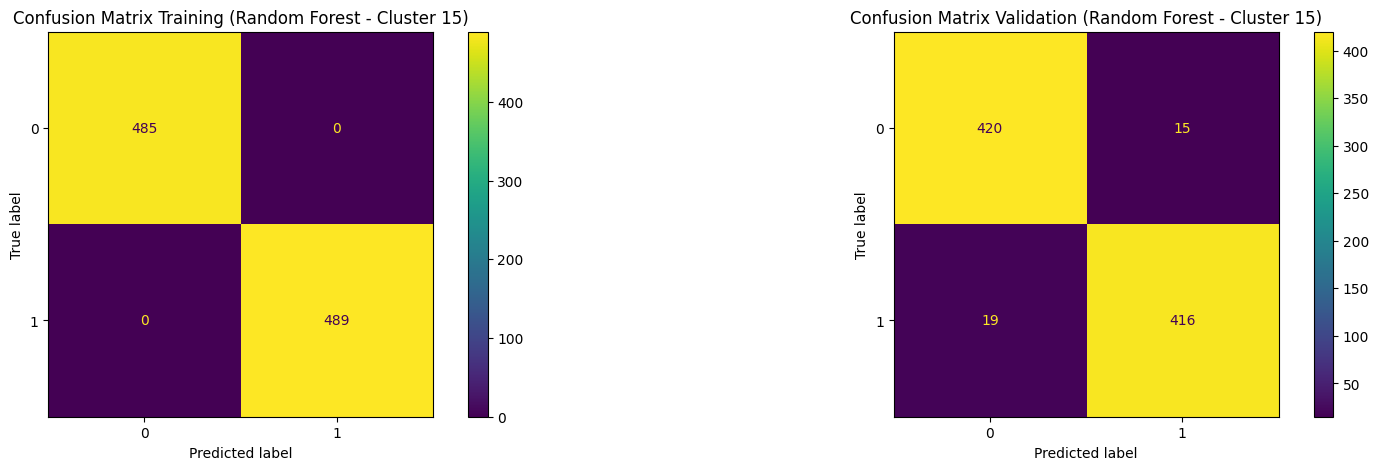

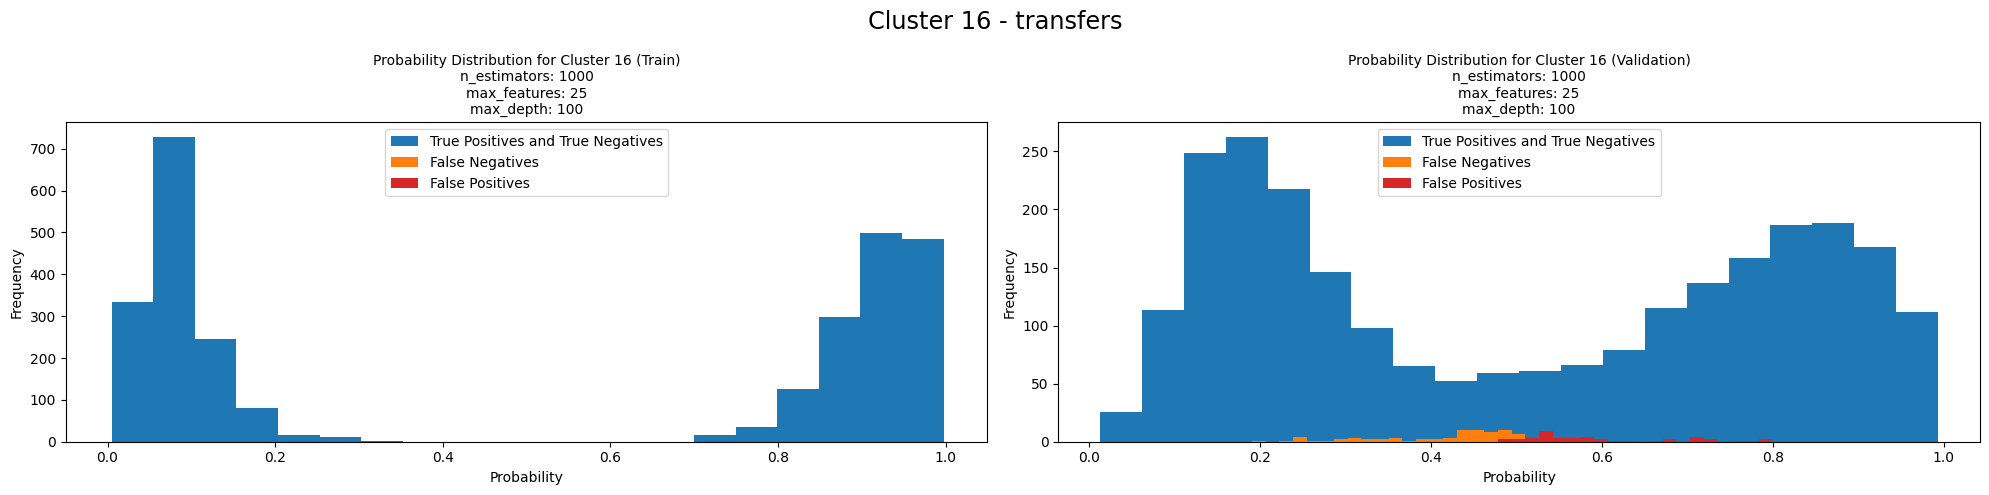

Evaluation Metrics Report Training (Random Forest - Cluster 16)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1416
         1.0       1.00      1.00      1.00      1456

    accuracy                           1.00      2872
   macro avg       1.00      1.00      1.00      2872
weighted avg       1.00      1.00      1.00      2872

Evaluation Metrics Report Validation (Random Forest - Cluster 16)
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1256
         1.0       0.97      0.94      0.95      1303

    accuracy                           0.95      2559
   macro avg       0.95      0.95      0.95      2559
weighted avg       0.95      0.95      0.95      2559



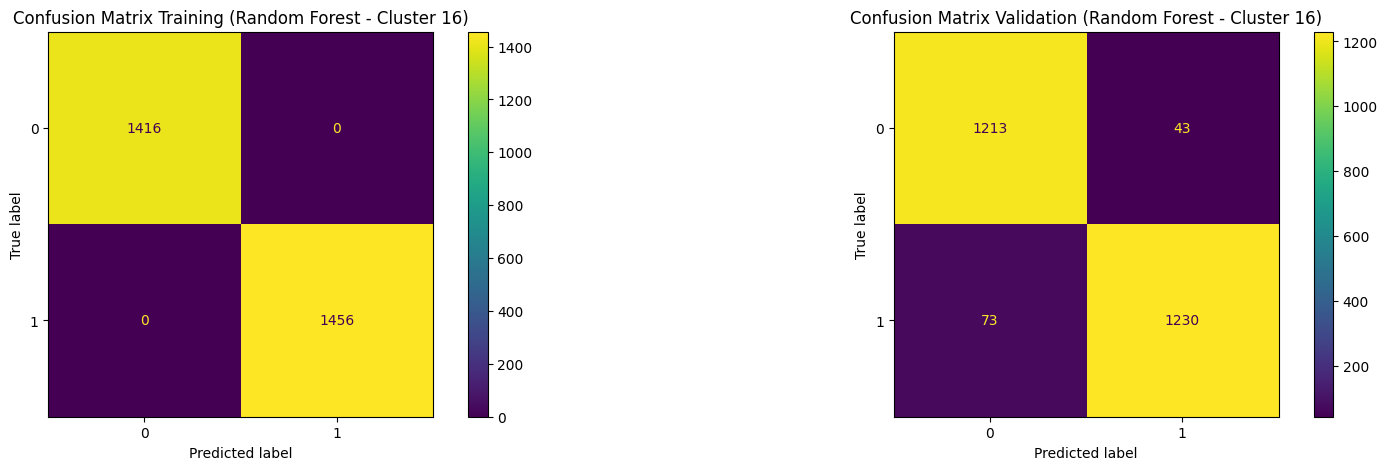

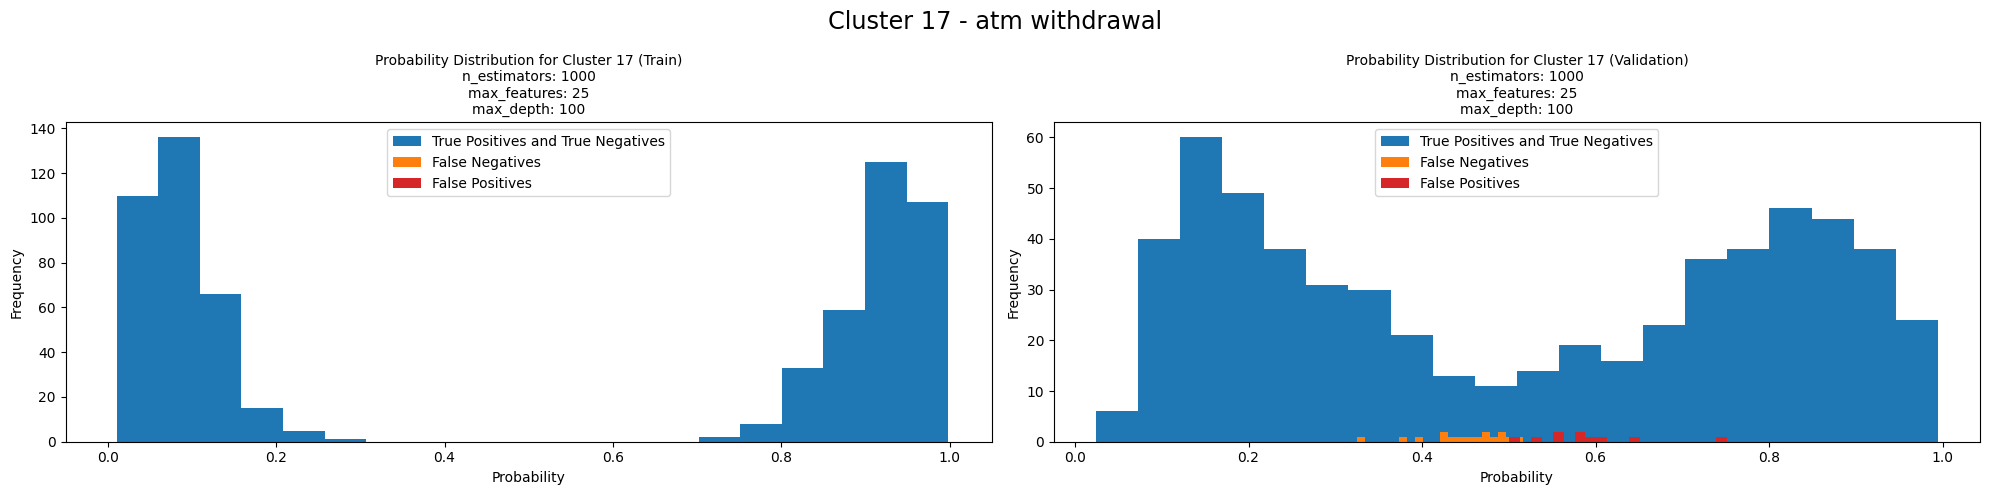

Evaluation Metrics Report Training (Random Forest - Cluster 17)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       333
         1.0       1.00      1.00      1.00       334

    accuracy                           1.00       667
   macro avg       1.00      1.00      1.00       667
weighted avg       1.00      1.00      1.00       667

Evaluation Metrics Report Validation (Random Forest - Cluster 17)
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       293
         1.0       0.97      0.95      0.96       304

    accuracy                           0.96       597
   macro avg       0.96      0.96      0.96       597
weighted avg       0.96      0.96      0.96       597



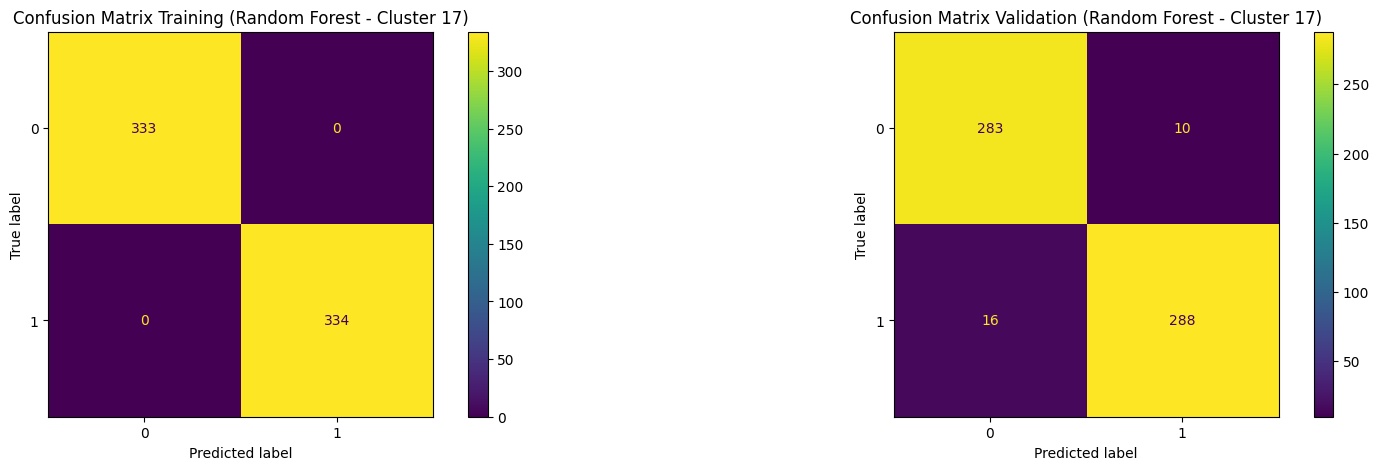

In [ ]:
# testing_cluster_numbers = [11, 16, 19]

# cluster topic dictionary
topic_dict = {-1:"noise", 0:"crypto", 1:"stocks", 2:"app interface", 3:"bank subscription plans", 
              4:"usage abroad", 5:"refunds", 6:"customer_service", 7:"account issues",
              8:"tedious paperwork (request of documents)", 
              9:"additional fees (e.g. card delivery and transaction fees)", 
              10:"business accounts", 11:"account verification", 12:"fraudulent transactions", 
              13:"online payments", 14:"frozen account and money holdout", 15:"exchange rates", 16:"transfers", 
              17:"atm withdrawal"}

# cluster numbers and filepath
cluster_numbers = np.unique(train_validation_df["grouped_cluster"])
results_filepath = f'model/random_forest/ovr_results/iteration_{iteration_number}/'

# retrieving optimal hyperparameters
n_estimators = 1000
max_features = 25
max_depth = 100

labels = [0,1]

for cluster_number in cluster_numbers:
    
    ovr_cluster_col = f"ovr_cluster_{cluster_number}"
    
    ############### loading training and validation results
    train_agg_df  = loading_file(results_filepath, f'train_cluster_{cluster_number}')
    valid_agg_df = loading_file(results_filepath, f'valid_cluster_{cluster_number}')
    
    # getting false negatives, false positives, true positives and true negatives
    fn_df_train, fp_df_train, tp_tn_df_train = fp_fn(train_agg_df, cluster_number)
    fn_df_valid, fp_df_valid, tp_tn_df_valid = fp_fn(valid_agg_df, cluster_number)
    
    ################# probability distributions
    title_train = f"Probability Distribution for Cluster {cluster_number} (Train)\nn_estimators: {n_estimators}\nmax_features: {max_features}\nmax_depth: {max_depth}"
    title_valid = f"Probability Distribution for Cluster {cluster_number} (Validation)\nn_estimators: {n_estimators}\nmax_features: {max_features}\nmax_depth: {max_depth}"

    # plotting probability distributions
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    axs[0].hist(train_agg_df.loc[:, "prob_average"], bins=20, label="True Positives and True Negatives")
    axs[0].hist(fn_df_train.loc[:, "prob_average"], bins=20, color="tab:orange", label="False Negatives")
    axs[0].hist(fp_df_train.loc[:, "prob_average"], bins=20, color="tab:red", label="False Positives")
    axs[0].set_title(title_train, fontsize=10)
    axs[0].set_xlabel("Probability")
    axs[0].set_ylabel("Frequency")
    axs[0].legend(loc=9)

    axs[1].hist(valid_agg_df.loc[:, "prob_average"], bins=20, label="True Positives and True Negatives")
    axs[1].hist(fn_df_valid.loc[:, "prob_average"], bins=20, color="tab:orange", label="False Negatives")
    axs[1].hist(fp_df_valid.loc[:, "prob_average"], bins=20, color="tab:red", label="False Positives")
    axs[1].set_title(title_valid, fontsize=10)
    axs[1].set_xlabel("Probability")
    axs[1].set_ylabel("Frequency")
    axs[1].legend(loc=9)

    fig.suptitle(f'Cluster {cluster_number} - {topic_dict[cluster_number]}', fontsize='xx-large')
    plt.tight_layout()
    plt.show()
    
    ############ Evaluation Metrics
    train_agg_pred = train_agg_df.loc[:, "pred_majority"]
    train_agg_label = train_agg_df.loc[:, ovr_cluster_col]

    valid_agg_pred = valid_agg_df.loc[:, "pred_majority"]
    valid_agg_label = valid_agg_df.loc[:, ovr_cluster_col]

    print(f"Evaluation Metrics Report Training (Random Forest - Cluster {cluster_number})")
    print(classification_report(train_agg_label, train_agg_pred))

    print(f"Evaluation Metrics Report Validation (Random Forest - Cluster {cluster_number})")
    print(classification_report(valid_agg_label, valid_agg_pred))
    
    ############# Confusion Matrix
    # plotting confusion matrices
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    # training confusion matrix
    cm_train = confusion_matrix(train_agg_label, train_agg_pred, labels=labels)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
    disp_train.plot(ax = axs[0])
    disp_train.ax_.set_title(f"Confusion Matrix Training (Random Forest - Cluster {cluster_number})")

    # validation confusion matrix
    cm_valid = confusion_matrix(valid_agg_label, valid_agg_pred, labels=labels)
    disp_valid = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=labels)
    disp_valid.plot(ax = axs[1])
    disp_valid.ax_.set_title(f"Confusion Matrix Validation (Random Forest - Cluster {cluster_number})")

    plt.show()
    
    ############## False Negatives (Validation)
    fp_valid_counter = Counter([cluster for cluster in fp_df_valid["grouped_cluster"]]).most_common()
    y_labels = [topic_dict[cluster] for (cluster, count) in fp_valid_counter]
    x_labels = [count for (cluster, count) in fp_valid_counter]
    cluster_number_list = [cluster for (cluster, count) in fp_valid_counter]

    y_labels.reverse()
    x_labels.reverse()
    cluster_number_list.reverse()

    # plotting distribution of clusters
    fig = go.Figure(data=[go.Bar(
        x=x_labels, 
        y=y_labels, 
        hovertemplate='<b>%{text}</b><extra></extra>',
        text=[f"cluster {cluster}" for cluster in cluster_number_list], 
        orientation='h')])

    fig.update_layout(title_text="Distribution of False Positives (Validation)",
                      yaxis = dict(tickfont = dict(size=10)),
                      xaxis = dict(tickfont = dict(size=10)),
                      showlegend=False)

    fig.show()
    
    print("\n\n")